In [1]:
import nibabel as nib
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from pathlib import Path
import scipy.io as sio

# Import models and utilities
import sys
sys.path.append(r'd:\AiProjects\verdict_benchmark')

from models.mlp import MLPRegressor
from models.cnn import CNNRegressor
from models.rnn import RNNRegressor
from models.residual_mlp import ResidualMLPRegressor
from models.transformer import TransformerRegressor
from models.moe_regressor import MoERegressor
from models.vae_regressor import VAERegressor
from models.tabnet_regressor import TabNetRegressor



# Easy target

In [2]:
# MODEL LOADING UTILITIES (from mlp_test_multi.ipynb)
import os, pickle, yaml
import torch
from functools import lru_cache
from importlib import import_module

print("Setting up model loading utilities...")

# Model specifications (consistent with mlp_test_multi.ipynb)
model_specs = [
    {"name": "CNN", "config": "cnn_advanced.yaml", "ckpt": "cnn_best.pt", "scaler": "cnn_scaler.pkl"},
    {"name": "MLP", "config": "mlp.yaml", "ckpt": "mlp_best.pt", "scaler": "mlp_scaler.pkl"},
    {"name": "ResNet", "config": "residual_mlp.yaml", "ckpt": "residual_mlp_best.pt", "scaler": "residual_mlp_scaler.pkl"},
    {"name": "MoE", "config": "moe_regressor.yaml", "ckpt": "moe_regressor_best.pt", "scaler": "moe_regressor_scaler.pkl"},
    {"name": "RNN", "config": "rnn.yaml", "ckpt": "rnn_best.pt", "scaler": "rnn_scaler.pkl"},
    {"name": "TabNet", "config": "tabnet_regressor.yaml", "ckpt": "tabnet_regressor_best.pt", "scaler": "tabnet_regressor_scaler.pkl"},
    {"name": "Transformer", "config": "transformer.yaml", "ckpt": "transformer_best.pt", "scaler": "transformer_scaler.pkl"},
    {"name": "VAE", "config": "vae_regressor.yaml", "ckpt": "vae_regressor_best.pt", "scaler": "vae_regressor_scaler.pkl"},
    {"name": "NLLS", "type": "ground_truth"},  # Special type for NLLS ground truth data
]

checkpoints_root = r'd:\AiProjects\verdict_benchmark\checkpoints'
configs_root = r'd:\AiProjects\verdict_benchmark\configs'

# Parameter names and indices
param_names = ['fic', 'fee', 'Dic', 'R', 'Dpar', 'Dtra', 'theta', 'phi']
param_indices = {p: i for i, p in enumerate(param_names)}

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()} "
          f"({torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB)")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Model loading utilities ready.")
print(f"Models to analyze: {[spec['name'] for spec in model_specs]}")

Setting up model loading utilities...
Using device: cuda
GPU: NVIDIA GeForce RTX 4080 Laptop GPU (12.0 GB)
Model loading utilities ready.
Models to analyze: ['CNN', 'MLP', 'ResNet', 'MoE', 'RNN', 'TabNet', 'Transformer', 'VAE', 'NLLS']


In [3]:
# NLLS GROUND TRUTH DATA PROCESSING UTILITIES (ROI-SPATIALLY-FILTERED)

def process_nlls_file_local(mat_file_path, verbose=True):
    """
    Local implementation of NLLS processing to avoid import issues.
    """
    try:
        # Load MATLAB file
        nlls_mat = sio.loadmat(str(mat_file_path))
        
        if verbose:
            print(f"Loading NLLS data from: {mat_file_path}")
        
        # Extract required structures
        model = nlls_mat['model']
        mlps = nlls_mat['mlps']
        
        # Parameter mapping for AstroSticks-dvZeppelin-Sphere model
        param_mapping = {
            'fic': 0,    # ficvf - intracellular fraction
            'fee': 1,    # fee - extracellular fraction  
            'R': 3,      # rads - cell radius (μm)
            'Dic': 4,    # di - intracellular diffusivity (μm²/ms)
        }
        
        # Extract parameters
        parameters = {}
        
        for param_name in ['fic', 'fee', 'Dic', 'R']:
            if param_name in param_mapping:
                col_idx = param_mapping[param_name]
                if col_idx < mlps.shape[1]:
                    parameters[param_name] = mlps[:, col_idx].copy()
        
        # Apply unit conversions to SI units
        if 'Dic' in parameters:
            # Convert Dic from μm²/ms to m²/s: 1 μm²/ms = 1e-9 m²/s
            parameters['Dic'] = parameters['Dic'] * 1e-9
        
        if 'R' in parameters:
            # Convert R from μm to m: 1 μm = 1e-6 m
            parameters['R'] = parameters['R'] * 1e-6
        
        if verbose:
            print(f"Extracted {len(parameters)} parameters for {len(parameters['fic'])} voxels")
        
        return parameters
        
    except Exception as e:
        if verbose:
            print(f"Error processing NLLS file: {str(e)}")
        return {}

def load_nlls_data_for_patient(patient_spec):
    """
    Load NLLS data using the correct tumor region mapping approach from NLLS_test.ipynb.
    
    Key insight: NLLS fitted parameters correspond to ALL tumor regions (ROI1 + ROI2),
    but ML models only use ROI1. We need to spatially filter NLLS results to extract
    only the ROI1 subset for fair comparison.
    """
    patient_id = patient_spec['id']
    who_grade = patient_spec['who_grade']
    
    print(f"  Loading NLLS ground truth for {patient_id} (ROI1-spatially-filtered)...")
    
    try:
        # Load NLLS fitted parameters (fitted on all tumor regions)
        nlls_params = process_nlls_file_local(patient_spec["nlls_path"], verbose=False)
        if 'fic' not in nlls_params:
            print(f"  WARNING: No fIC parameter found in NLLS data for {patient_id}")
            return None
        
        # Load ROI data to determine spatial correspondence
        roi_data = nib.load(patient_spec["roi_path"]).get_fdata()
        
        # Create tumor masks following NLLS_test.ipynb approach
        roi1_mask = roi_data == 1          # Tumor core (what ML models use)
        tumor_mask_all = (roi_data == 1) | (roi_data == 2)  # All tumor regions (what NLLS fits)
        
        roi1_voxel_count = np.sum(roi1_mask)
        tumor_all_count = np.sum(tumor_mask_all)
        nlls_fitted_count = len(nlls_params['fic'])
        
        print(f"    ROI1 voxels: {roi1_voxel_count}, All tumor: {tumor_all_count}, NLLS fitted: {nlls_fitted_count}")
        
        # Use spatial filtering approach following NLLS_test.ipynb method
        print("    ✓ Using spatial filtering to extract ROI1 subset from NLLS fitted data")
        
        # Get 3D coordinates of all tumor voxels (what NLLS fitted on)
        tumor_coords = np.where(tumor_mask_all)
        
        # Create mapping from tumor voxels to ROI1 subset
        # Find which positions in the tumor_coords correspond to ROI1
        roi1_indices_in_tumor = []
        for i, (z, y, x) in enumerate(zip(*tumor_coords)):
            if roi_data[z, y, x] == 1:  # This voxel is in ROI1
                roi1_indices_in_tumor.append(i)
        
        # Extract NLLS fIC values corresponding to ROI1 voxels only
        roi1_fic_values = nlls_params['fic'][roi1_indices_in_tumor]
        
        print(f"    {patient_id}: Extracted {len(roi1_fic_values)} ROI1 fIC values from {nlls_fitted_count} NLLS fitted voxels (Grade {who_grade})")
        
        return {
            'who_grade': who_grade,
            'fic_values': roi1_fic_values,
            'n_voxels': len(roi1_fic_values)
        }
        
    except Exception as e:
        print(f"  ERROR processing NLLS data for {patient_id}: {e}")
        return None

print("NLLS ground truth processing utilities loaded.")

NLLS ground truth processing utilities loaded.


# NLLS Ground Truth Integration

**Added NLLS as comparison baseline:**
- NLLS data loaded using the `nlls_processor.py` utility
- NLLS treated as a special "model" type for consistent analysis
- fIC values extracted directly from NLLS fitted parameters
- Integrated into the same analysis pipeline as ML models

**Key features:**
- ✅ NLLS data automatically loaded for each patient
- ✅ Same data structure as ML model predictions  
- ✅ Included in all visualizations and statistical comparisons
- ✅ Shows ground truth performance vs. ML model predictions

In [4]:
@lru_cache(maxsize=None)
def load_model_generic(model_name, config_file, ckpt_file, scaler_file):
    """Load model, weights, and scaler - cached for efficiency"""
    print(f"Loading {model_name} (cached thereafter)...")
    
    # Load config
    cfg_path = os.path.join(configs_root, config_file)
    with open(cfg_path, 'r', encoding='utf-8') as f:
        cfg = yaml.safe_load(f)
    
    # Import and create model
    module = import_module(f"models.{cfg['model']['type']}")
    ModelCls = getattr(module, cfg['model']['class_name'])
    model = ModelCls(input_dim=153, output_dim=8, **cfg['model']['params'])

    # Load weights
    ckpt_path = os.path.join(checkpoints_root, ckpt_file)
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state_dict = torch.load(ckpt_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    model.to(device).eval()

    # Load scaler
    scaler_path = os.path.join(checkpoints_root, scaler_file)
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"Scaler not found: {scaler_path}")
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    
    return model, scaler, cfg

def extract_primary_output(pred):
    """Return primary tensor from possible (tensor, tuple, list, dict) model outputs."""
    if isinstance(pred, (list, tuple)) and len(pred) > 0:
        pred = pred[0]
    elif isinstance(pred, dict):
        for k in ('output', 'pred', 'logits', 'recon', 'y_hat'):
            if k in pred:
                pred = pred[k]
                break
    if not torch.is_tensor(pred):
        raise TypeError(f"Unsupported model output type: {type(pred)}")
    return pred

def param_transform(p):
    """Map raw model parameters to VERDICT params (from mlp_test_multi.ipynb)"""
    c0 = np.cos(p[:, 0])
    c1 = np.cos(p[:, 1])
    fic = c0**2
    fee = (1 - fic) * (c1**2)
    Dic = p[:, 2]
    R = p[:, 3]
    Dpar = p[:, 4]
    Dtra = p[:, 5] * Dpar
    theta = p[:, 6]
    phi = p[:, 7]
    return np.column_stack([fic, fee, Dic, R, Dpar, Dtra, theta, phi])

print("Model loading functions ready.")

Model loading functions ready.


In [5]:
def load_patient_data(patient_spec):
    """Load brain data and extract ROI 1 tumor core for a patient"""
    patient_id = patient_spec["id"]
    roi_path = patient_spec["roi_path"]
    brain_path = patient_spec["brain_path"]
    
    print(f"\nLoading {patient_id} (WHO Grade {patient_spec['who_grade']})...")
    print(f"  ROI path: {roi_path}")
    print(f"  Brain path: {brain_path}")
    
    # Verify files exist
    if not os.path.exists(roi_path):
        raise FileNotFoundError(f"ROI file not found: {roi_path}")
    if not os.path.exists(brain_path):
        raise FileNotFoundError(f"Brain file not found: {brain_path}")
    
    # Load brain data
    brain_img = nib.load(brain_path)
    brain_data = brain_img.get_fdata()
    print(f"  Brain data shape: {brain_data.shape}")
    
    # Load ROI data
    roi_img = nib.load(roi_path)
    roi_data = roi_img.get_fdata()
    print(f"  ROI data shape: {roi_data.shape}")
    
    # Extract ROI 1 (tumor core)
    roi1_mask = extract_roi1_tumor_core(roi_data)
    
    # Extract signals from tumor core
    if np.any(roi1_mask):
        tumor_signals = brain_data[roi1_mask]  # Shape: (n_voxels, 153)
        print(f"  Tumor core voxels: {tumor_signals.shape[0]}")
        print(f"  Signal range: [{tumor_signals.min():.3f}, {tumor_signals.max():.3f}]")
        
        return {
            "patient_id": patient_id,
            "who_grade": patient_spec["who_grade"],
            "tumor_signals": tumor_signals
        }
    else:
        print(f"  WARNING: No tumor core found for {patient_id}")
        return None

In [6]:
# PATIENT DATA LOADING AND ROI EXTRACTION

# Patient specifications with WHO grades and explicit brain paths
patient_specs = [
    {"id": "Patient08", "who_grade": 4, 
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_ROIs_to_DWI_small.nii',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient12", "who_grade": 4,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient12\Patient12_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient12\Patient12_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient12\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient03", "who_grade": 4, 
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient03\Patient03_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient03\Patient03_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient03\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id":"Patient13", "who_grade": 4,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient13\Patient13_ROIs_to_DWI_small.nii',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient13\Patient13_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient13\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id":"Patient17", "who_grade": 4,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient17\Patient17_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient17\Patient17_mc_normb0.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient17\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},

    {"id": "Patient01", "who_grade": 3,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient01\Patient01_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient01\Patient01_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient01\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient02", "who_grade": 3,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient02\Patient02_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient02\Patient02_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient02\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient05", "who_grade": 3,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\Patient05_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\Patient05_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient16", "who_grade": 3,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient16\Patient16_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient16\Patient16_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient16\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient18", "who_grade": 3,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient18\Patient18_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient18\Patient18_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient18\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
     
    {"id": "Patient09", "who_grade": 2,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient09\Patient09_ROIs_to_DWI_small.nii',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient09\Patient09_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient09\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient06", "who_grade": 2,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient06\Patient06_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient06\Patient06_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient06\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient19", "who_grade": 2,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient19\Patient19_ROIs_to_DWI_small.nii.gz',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient19\Patient19_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient19\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
    {"id": "Patient21", "who_grade": 2,
     "roi_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient21\Patient21_ROIs_to_DWI_small.nii',
     "brain_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient21\Patient21_postNODDI.nii.gz',
     "nlls_path": r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient21\AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat'},
]

def extract_roi1_tumor_core(roi_data):
    """
    Extract ROI 1 (tumor core) from ROI data.
    Handles multi-channel, integer-labeled, or binary formats.
    """
    if roi_data.ndim == 4:  # Multi-channel
        roi1_mask = roi_data[:, :, :, 0] > 0  # Use channel 0 as ROI 1
        print("  Multi-channel ROI detected, using channel 0 as ROI 1")
    elif roi_data.ndim == 3:  # Single volume
        unique_vals = np.unique(roi_data)
        print(f"  ROI unique values: {unique_vals}")
        if len(unique_vals) == 2 and 0 in unique_vals and 1 in unique_vals:
            # Binary ROI
            roi1_mask = roi_data == 1
            print("  Binary ROI detected, using label==1 as ROI 1")
        elif len(unique_vals) > 2:
            # Integer-labeled ROI
            roi1_mask = roi_data == 1
            print("  Integer-labeled ROI detected, using label==1 as ROI 1")
        else:
            # Fallback: use any non-zero as ROI 1
            roi1_mask = roi_data > 0
            print("  Using any non-zero values as ROI 1")
    else:
        raise ValueError(f"Unexpected ROI data dimensions: {roi_data.shape}")
    
    return roi1_mask

In [7]:
# LOAD ALL PATIENT DATA
print("=" * 80)
print("LOADING PATIENT DATA AND EXTRACTING TUMOR CORES")
print("=" * 80)

# Load all patient data (skip missing patients)
patient_data = {}
for patient_spec in patient_specs:
    try:
        data = load_patient_data(patient_spec)
        if data is not None:
            patient_data[data["patient_id"]] = data
    except FileNotFoundError as e:
        print(f"  WARNING: Skipping {patient_spec['id']} - file not found: {e}")
        continue

print(f"\nSuccessfully loaded {len(patient_data)} patients")
print(f"Patients: {list(patient_data.keys())}")

# Summary of loaded data
print("\nPatient Summary:")
for patient_id, data in patient_data.items():
    print(f"  {patient_id}: WHO Grade {data['who_grade']}, "
          f"{data['tumor_signals'].shape[0]} tumor core voxels")

LOADING PATIENT DATA AND EXTRACTING TUMOR CORES

Loading Patient08 (WHO Grade 4)...
  ROI path: D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_ROIs_to_DWI_small.nii
  Brain path: D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_postNODDI.nii.gz
  Brain data shape: (112, 112, 60, 153)
  ROI data shape: (112, 112, 60)
  ROI unique values: [0. 1. 2.]
  Integer-labeled ROI detected, using label==1 as ROI 1
  Tumor core voxels: 104
  Signal range: [0.016, 1.142]

Loading Patient12 (WHO Grade 4)...
  ROI path: D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient12\Patient12_ROIs_to_DWI_small.nii.gz
  Brain path: D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient12\Patient12_postNODDI.nii.gz
  Brain data shape: (112, 112, 60, 153)
  ROI data shape: (112, 112, 60)
  ROI unique values: [0. 1. 2.]
  Integer-labeled ROI detected, using label==1 as ROI 1
  Tumor core voxels: 104
  Signal range: [0.016, 1.142]

Loading Patient12 (WHO Grade 4)...
 

In [8]:
# RUN INFERENCE ACROSS ALL MODELS AND PATIENTS (INCLUDING NLLS GROUND TRUTH)
print("=" * 80)
print("RUNNING MODEL INFERENCE ON ALL PATIENTS")
print("=" * 80)

# Store results for each model-patient combination
all_results = {}

with torch.inference_mode():
    for spec in model_specs:
        model_name = spec['name']
        print(f"\nProcessing model: {model_name}")
        
        # Check if this is NLLS (ground truth)
        if spec.get('type') == 'ground_truth':
            # Handle NLLS ground truth data
            all_results[model_name] = {}
            
            for patient_spec in patient_specs:
                patient_id = patient_spec['id']
                
                # Only process patients that have signal data loaded
                if patient_id in patient_data:
                    nlls_result = load_nlls_data_for_patient(patient_spec)
                    
                    if nlls_result is not None:
                        all_results[model_name][patient_id] = nlls_result
        else:
            # Handle regular ML models
            # Load model
            model, scaler, _ = load_model_generic(
                model_name, spec['config'], spec['ckpt'], spec['scaler']
            )
            
            all_results[model_name] = {}
            
            for patient_id, data in patient_data.items():
                print(f"  Inferring {patient_id}...")
                
                # Get tumor signals
                tumor_signals = data['tumor_signals']
                
                # Run inference
                inp = torch.as_tensor(tumor_signals, dtype=torch.float32, device=device)
                pred = extract_primary_output(model(inp)).detach().cpu().numpy()
                pred = pred.reshape(len(pred), -1)  # [N, 8]
                
                # Denormalize and transform to VERDICT parameters
                pred_denorm = scaler.inverse_transform(pred)
                verdict_params = param_transform(pred_denorm)
                
                # Extract fIC values (parameter index 0)
                fic_values = verdict_params[:, param_indices['fic']]
                
                # Store results
                all_results[model_name][patient_id] = {
                    'who_grade': data['who_grade'],
                    'fic_values': fic_values,
                    'n_voxels': len(fic_values)
                }
                
                print(f"    Processed {len(fic_values)} voxels, "
                      f"fIC range: [{fic_values.min():.3f}, {fic_values.max():.3f}]")

print(f"\nInference completed for {len(model_specs)} models across {len(patient_data)} patients")

RUNNING MODEL INFERENCE ON ALL PATIENTS

Processing model: CNN
Loading CNN (cached thereafter)...
  Inferring Patient08...
    Processed 104 voxels, fIC range: [0.029, 0.302]
  Inferring Patient12...
    Processed 1230 voxels, fIC range: [0.008, 0.921]
  Inferring Patient03...
    Processed 1560 voxels, fIC range: [0.000, 0.990]
  Inferring Patient13...
    Processed 2164 voxels, fIC range: [0.000, 0.987]
  Inferring Patient17...
    Processed 104 voxels, fIC range: [0.029, 0.302]
  Inferring Patient12...
    Processed 1230 voxels, fIC range: [0.008, 0.921]
  Inferring Patient03...
    Processed 1560 voxels, fIC range: [0.000, 0.990]
  Inferring Patient13...
    Processed 2164 voxels, fIC range: [0.000, 0.987]
  Inferring Patient17...
    Processed 1960 voxels, fIC range: [0.035, 0.247]
  Inferring Patient01...
    Processed 47 voxels, fIC range: [0.029, 0.389]
  Inferring Patient02...
    Processed 31 voxels, fIC range: [0.124, 0.402]
  Inferring Patient05...
    Processed 2 voxels, f

In [9]:
# BUILD TIDY DATAFRAME FOR ANALYSIS
print("=" * 80)
print("BUILDING TIDY DATAFRAME")
print("=" * 80)

# Create tidy dataframe: patient_id | who_grade | model_name | fic_value
tidy_data = []

for model_name, model_results in all_results.items():
    for patient_id, patient_results in model_results.items():
        who_grade = patient_results['who_grade']
        fic_values = patient_results['fic_values']
        
        # Add each fIC value as a separate row
        for fic_value in fic_values:
            tidy_data.append({
                'patient_id': patient_id,
                'who_grade': who_grade,
                'model_name': model_name,
                'fic_value': fic_value
            })

# Convert to DataFrame
df = pd.DataFrame(tidy_data)

print(f"Tidy dataframe created with {len(df)} rows")
print(f"Unique models: {df['model_name'].nunique()}")
print(f"Unique patients: {df['patient_id'].nunique()}")
print(f"WHO grades: {sorted(df['who_grade'].unique())}")

# Display summary statistics
print("\nSummary by WHO Grade:")
grade_summary = df.groupby(['who_grade', 'model_name'])['fic_value'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(4)
print(grade_summary)

print("\nDataframe sample:")
print(df.head(10))

BUILDING TIDY DATAFRAME
Tidy dataframe created with 101293 rows
Unique models: 9
Unique patients: 14
WHO grades: [np.int64(2), np.int64(3), np.int64(4)]

Summary by WHO Grade:
                       count    mean     std     min     max
who_grade model_name                                        
2         CNN           3808  0.0868  0.0340  0.0007  0.5875
          MLP           3808  0.0411  0.0439  0.0000  1.0000
          MoE           3808  0.0322  0.0559  0.0000  0.9908
          NLLS          3808  0.0784  0.1378  0.0000  1.0000
          RNN           3808  0.0587  0.0288  0.0000  0.5022
          ResNet        3808  0.0611  0.0497  0.0000  0.7619
          TabNet        3808  0.1009  0.0624  0.0000  0.9990
          Transformer   3808  0.0568  0.0384  0.0000  0.4486
          VAE           3808  0.0661  0.0312  0.0006  0.4342
3         CNN            429  0.1785  0.0963  0.0288  0.6215
          MLP            429  0.0835  0.0823  0.0000  0.8286
          MoE            429  0

Creating WHO Grade 2 vs 4 comparison visualization...


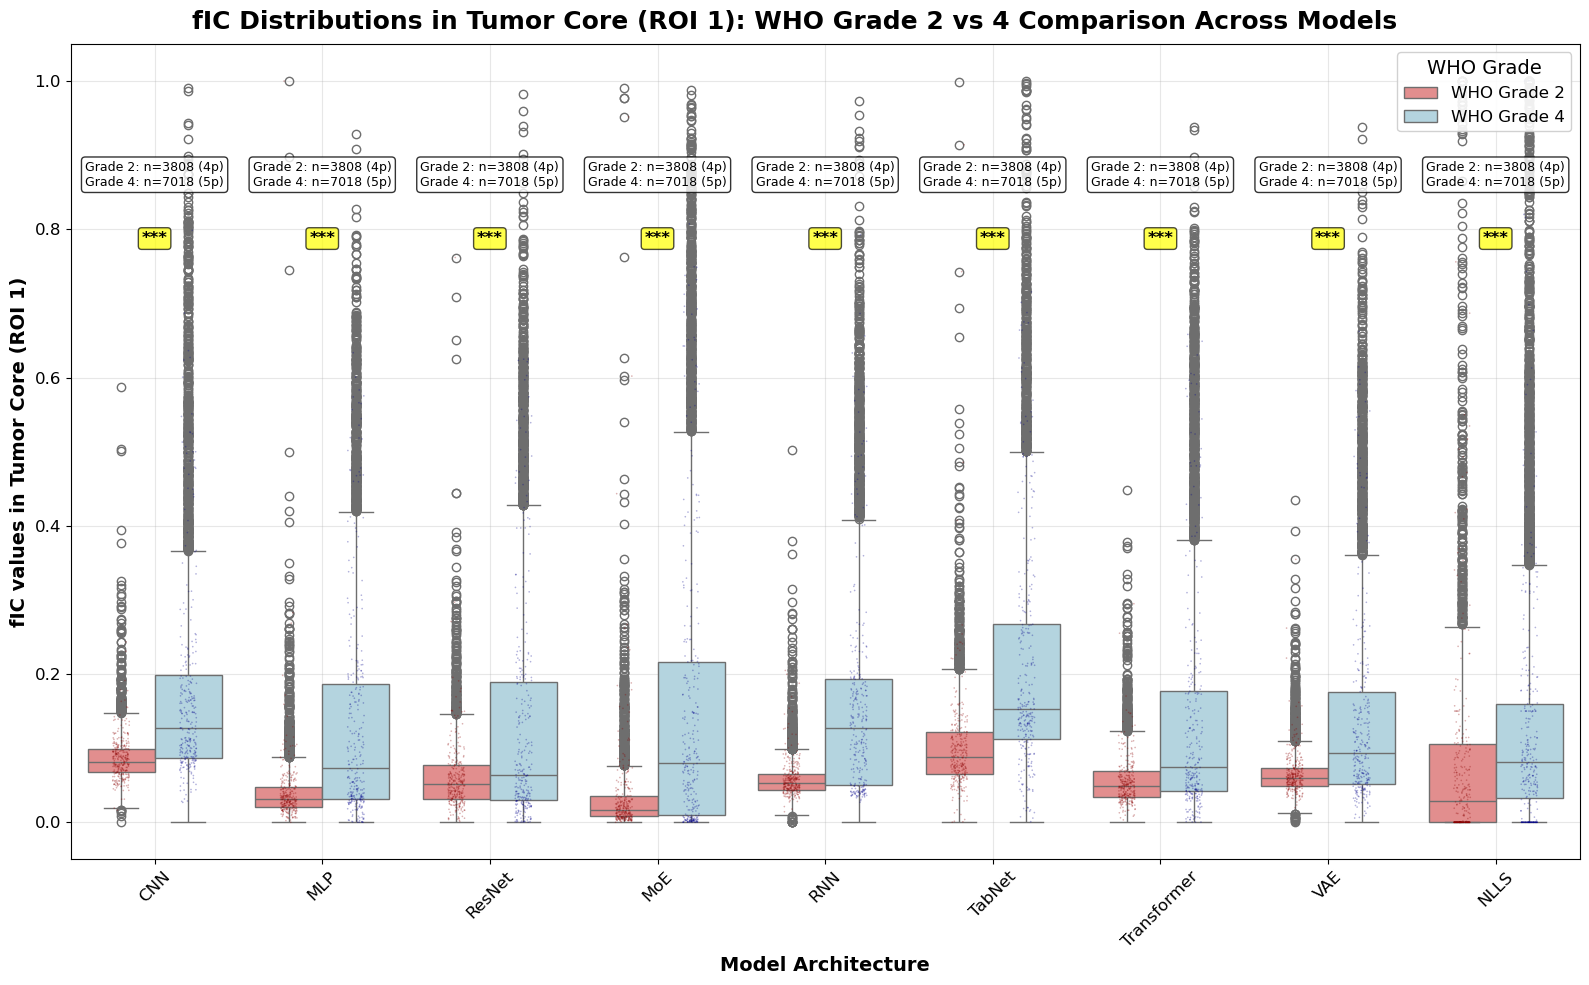


WHO Grade 2 vs 4 Visualization Summary:
Y-axis range: [-0.050, 1.050]
Statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant

Quick Grade 2 vs 4 Comparison (Mean fIC ± SD):
CNN         : Grade 2 = 0.087±0.034, Grade 4 = 0.170±0.133
MLP         : Grade 2 = 0.041±0.044, Grade 4 = 0.131±0.143
ResNet      : Grade 2 = 0.061±0.050, Grade 4 = 0.135±0.157
MoE         : Grade 2 = 0.032±0.056, Grade 4 = 0.158±0.201
RNN         : Grade 2 = 0.059±0.029, Grade 4 = 0.159±0.139
TabNet      : Grade 2 = 0.101±0.062, Grade 4 = 0.208±0.157
Transformer : Grade 2 = 0.057±0.038, Grade 4 = 0.139±0.152
VAE         : Grade 2 = 0.066±0.031, Grade 4 = 0.141±0.133
NLLS        : Grade 2 = 0.078±0.138, Grade 4 = 0.144±0.190

WHO Grade 2 vs 4 visualization completed!


In [10]:
# UNIFIED VISUALIZATION: WHO GRADE 2 vs 4 COMPARISON
print("Creating WHO Grade 2 vs 4 comparison visualization...")

# Filter data for WHO grades 2 and 4 only
df_2v4 = df[df['who_grade'].isin([2, 4])].copy()

if len(df_2v4) > 0:
    # Create a single comprehensive figure with better spacing
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    fig.suptitle('fIC Distributions in Tumor Core (ROI 1): WHO Grade 2 vs 4 Comparison Across Models', 
                 fontsize=18, fontweight='bold', y=0.98)

    # Adjust subplot to leave more space at the top
    plt.subplots_adjust(top=0.85)

    # Use seaborn box plot with WHO grade as hue for direct comparison
    sns.boxplot(data=df_2v4, x='model_name', y='fic_value', hue='who_grade', 
                ax=ax, palette=['lightcoral', 'lightblue'])

    # Add jittered points (subsample for clarity)
    df_sub_2v4 = df_2v4.groupby(['model_name', 'who_grade']).apply(
        lambda x: x.sample(min(300, len(x)), random_state=42),
        include_groups=False
    ).reset_index()

    # Fix the column structure after groupby
    df_sub_2v4 = df_sub_2v4.drop(columns=['level_2']) if 'level_2' in df_sub_2v4.columns else df_sub_2v4

    sns.stripplot(data=df_sub_2v4, x='model_name', y='fic_value', hue='who_grade', 
                  ax=ax, size=1.2, alpha=0.3, dodge=True, palette=['darkred', 'darkblue'])

    # Customize the plot
    ax.set_xlabel('Model Architecture', fontsize=14, fontweight='bold')
    ax.set_ylabel('fIC values in Tumor Core (ROI 1)', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, alpha=0.3)

    # Set consistent y-axis limits
    global_min_2v4 = df_2v4['fic_value'].min()
    global_max_2v4 = df_2v4['fic_value'].max()
    y_margin_2v4 = (global_max_2v4 - global_min_2v4) * 0.05
    y_lim_2v4 = (global_min_2v4 - y_margin_2v4, global_max_2v4 + y_margin_2v4)
    ax.set_ylim(y_lim_2v4)
    
    # Enhanced legend
    handles, labels = ax.get_legend_handles_labels()
    # Remove duplicate legends from stripplot
    ax.legend(handles[:2], ['WHO Grade 2', 'WHO Grade 4'], 
              title='WHO Grade', title_fontsize=14, fontsize=12, 
              loc='upper right', framealpha=0.9)

    # Add sample size annotations for each model (positioned lower to avoid title overlap)
    for i, model in enumerate([spec['name'] for spec in model_specs]):
        # Grade 2 and 4 data
        grade2_data = df_2v4[(df_2v4['model_name'] == model) & (df_2v4['who_grade'] == 2)]
        grade4_data = df_2v4[(df_2v4['model_name'] == model) & (df_2v4['who_grade'] == 4)]
        
        annotation_text = ""
        if not grade2_data.empty:
            grade2_patients = grade2_data['patient_id'].nunique()
            grade2_voxels = len(grade2_data)
            annotation_text += f'Grade 2: n={grade2_voxels} ({grade2_patients}p)'
            
        if not grade4_data.empty:
            grade4_patients = grade4_data['patient_id'].nunique()
            grade4_voxels = len(grade4_data)
            if annotation_text:
                annotation_text += f'\nGrade 4: n={grade4_voxels} ({grade4_patients}p)'
            else:
                annotation_text = f'Grade 4: n={grade4_voxels} ({grade4_patients}p)'
        
        # Add annotation above each model (lowered position to avoid title overlap)
        if annotation_text:
            ax.text(i, y_lim_2v4[1] * 0.85, annotation_text,
                   ha='center', va='top', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Add statistical significance indicators (positioned lower)
    try:
        from scipy.stats import mannwhitneyu
        
        for i, model in enumerate([spec['name'] for spec in model_specs]):
            df_model = df_2v4[df_2v4['model_name'] == model]
            grade2_data = df_model[df_model['who_grade'] == 2]['fic_value']
            grade4_data = df_model[df_model['who_grade'] == 4]['fic_value']
            
            if len(grade2_data) > 0 and len(grade4_data) > 0:
                _, p_value = mannwhitneyu(grade2_data, grade4_data, alternative='two-sided')
                
                # Add significance stars
                if p_value < 0.001:
                    sig_text = "***"
                elif p_value < 0.01:
                    sig_text = "**" 
                elif p_value < 0.05:
                    sig_text = "*"
                else:
                    sig_text = "ns"
                
                ax.text(i, y_lim_2v4[1] * 0.75, sig_text, 
                       ha='center', va='center', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))

    except ImportError:
        pass

    plt.tight_layout()
    plt.show()

    # Print summary comparison
    print("\nWHO Grade 2 vs 4 Visualization Summary:")
    print(f"Y-axis range: [{y_lim_2v4[0]:.3f}, {y_lim_2v4[1]:.3f}]")
    print("Statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

    # Summary statistics comparison
    grade_comparison_2v4 = df_2v4.groupby(['who_grade', 'model_name'])['fic_value'].agg([
        'mean', 'std', 'count'
    ]).round(4)

    print("\nQuick Grade 2 vs 4 Comparison (Mean fIC ± SD):")
    for model in [spec['name'] for spec in model_specs]:
        grade2_stats = ""
        grade4_stats = ""
        
        try:
            if (2, model) in grade_comparison_2v4.index:
                grade2_mean = grade_comparison_2v4.loc[(2, model), 'mean']
                grade2_std = grade_comparison_2v4.loc[(2, model), 'std']
                grade2_stats = f"Grade 2 = {grade2_mean:.3f}±{grade2_std:.3f}"
        except KeyError:
            pass
            
        try:
            if (4, model) in grade_comparison_2v4.index:
                grade4_mean = grade_comparison_2v4.loc[(4, model), 'mean'] 
                grade4_std = grade_comparison_2v4.loc[(4, model), 'std']
                grade4_stats = f"Grade 4 = {grade4_mean:.3f}±{grade4_std:.3f}"
        except KeyError:
            pass
        
        if grade2_stats or grade4_stats:
            comparison_text = ", ".join(filter(None, [grade2_stats, grade4_stats]))
            print(f"{model:12}: {comparison_text}")
        else:
            print(f"{model:12}: No data available")

    print("\nWHO Grade 2 vs 4 visualization completed!")
else:
    print("No data available for WHO Grade 2 vs 4 comparison")

Creating WHO Grade 2 vs 4 comparison with patient-averaged fIC values...
Patient-averaged dataset created with 81 patient-model combinations
Grade 2 patients: 4
Grade 4 patients: 5

Statistical Testing (Patient-Averaged Data):
CNN: Grade 2 vs 4 comparison p-value = 0.2857 (ns)
MLP: Grade 2 vs 4 comparison p-value = 0.5556 (ns)
ResNet: Grade 2 vs 4 comparison p-value = 0.5556 (ns)
MoE: Grade 2 vs 4 comparison p-value = 0.4127 (ns)
RNN: Grade 2 vs 4 comparison p-value = 0.4127 (ns)
TabNet: Grade 2 vs 4 comparison p-value = 0.1905 (ns)
Transformer: Grade 2 vs 4 comparison p-value = 0.4127 (ns)
VAE: Grade 2 vs 4 comparison p-value = 0.5556 (ns)
NLLS: Grade 2 vs 4 comparison p-value = 0.5556 (ns)
MoE: Grade 2 vs 4 comparison p-value = 0.4127 (ns)
RNN: Grade 2 vs 4 comparison p-value = 0.4127 (ns)
TabNet: Grade 2 vs 4 comparison p-value = 0.1905 (ns)
Transformer: Grade 2 vs 4 comparison p-value = 0.4127 (ns)
VAE: Grade 2 vs 4 comparison p-value = 0.5556 (ns)
NLLS: Grade 2 vs 4 comparison p-v

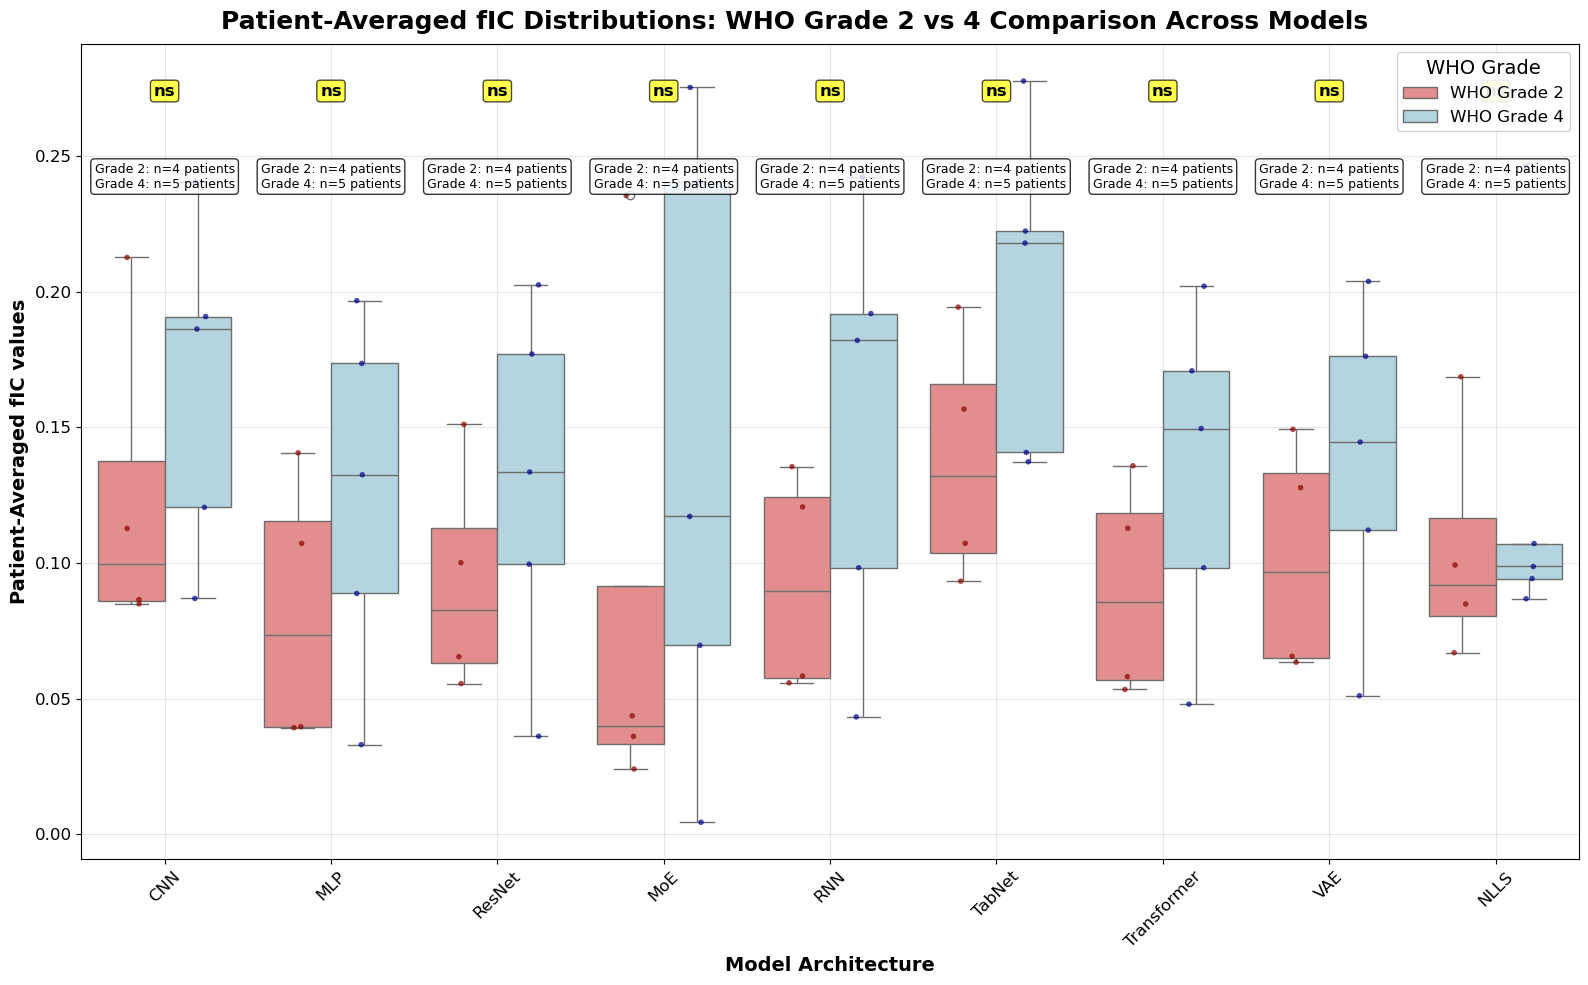


Summary Statistics (Patient-Averaged):
                       count    mean     std  median     min     max
model_name  who_grade                                               
CNN         2              4  0.1242  0.0603  0.0997  0.0850  0.2126
            4              5  0.1651  0.0610  0.1863  0.0870  0.2406
MLP         2              4  0.0817  0.0506  0.0735  0.0394  0.1406
            4              5  0.1249  0.0658  0.1326  0.0331  0.1967
MoE         2              4  0.0849  0.1007  0.0400  0.0241  0.2355
            4              5  0.1414  0.1142  0.1172  0.0045  0.2753
NLLS        2              4  0.1050  0.0445  0.0921  0.0670  0.1687
            4              5  0.1267  0.0672  0.0988  0.0869  0.2461
RNN         2              4  0.0926  0.0414  0.0896  0.0559  0.1355
            4              5  0.1516  0.0796  0.1821  0.0433  0.2423
ResNet      2              4  0.0931  0.0432  0.0828  0.0556  0.1511
            4              5  0.1298  0.0656  0.1336  0.0362  0

In [11]:
# PATIENT-AVERAGED ANALYSIS: WHO GRADE 2 vs 4 COMPARISON
print("Creating WHO Grade 2 vs 4 comparison with patient-averaged fIC values...")

# Filter data for WHO grades 2 and 4 only
df_2v4 = df[df['who_grade'].isin([2, 4])].copy()

if len(df_2v4) > 0:
    # Calculate patient-averaged fIC values for each model
    patient_averaged_data = []
    
    for model_name in df_2v4['model_name'].unique():
        model_data = df_2v4[df_2v4['model_name'] == model_name]
        
        # Group by patient and calculate mean fIC for each patient
        patient_means = model_data.groupby(['patient_id', 'who_grade'])['fic_value'].mean().reset_index()
        
        # Add model name back
        patient_means['model_name'] = model_name
        patient_averaged_data.append(patient_means)
    
    # Combine all patient-averaged data
    df_patient_avg = pd.concat(patient_averaged_data, ignore_index=True)
    
    print(f"Patient-averaged dataset created with {len(df_patient_avg)} patient-model combinations")
    print(f"Grade 2 patients: {len(df_patient_avg[df_patient_avg['who_grade'] == 2]['patient_id'].unique())}")
    print(f"Grade 4 patients: {len(df_patient_avg[df_patient_avg['who_grade'] == 4]['patient_id'].unique())}")
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    fig.suptitle('Patient-Averaged fIC Distributions: WHO Grade 2 vs 4 Comparison Across Models', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Adjust subplot to leave more space at the top
    plt.subplots_adjust(top=0.85)
    
    # Use seaborn box plot with WHO grade as hue for direct comparison
    sns.boxplot(data=df_patient_avg, x='model_name', y='fic_value', hue='who_grade', 
                ax=ax, palette=['lightcoral', 'lightblue'])
    
    # Add individual patient points (jittered)
    sns.stripplot(data=df_patient_avg, x='model_name', y='fic_value', hue='who_grade', 
                  ax=ax, size=4, alpha=0.7, dodge=True, palette=['darkred', 'darkblue'])
    
    # Customize the plot
    ax.set_xlabel('Model Architecture', fontsize=14, fontweight='bold')
    ax.set_ylabel('Patient-Averaged fIC values', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, alpha=0.3)
    
    # Set consistent y-axis limits
    global_min = df_patient_avg['fic_value'].min()
    global_max = df_patient_avg['fic_value'].max()
    y_margin = (global_max - global_min) * 0.05
    y_lim = (global_min - y_margin, global_max + y_margin)
    ax.set_ylim(y_lim)
    
    # Enhanced legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ['WHO Grade 2', 'WHO Grade 4'], 
              title='WHO Grade', title_fontsize=14, fontsize=12, 
              loc='upper right', framealpha=0.9)
    
    # Add sample size annotations for each model
    for i, model in enumerate([spec['name'] for spec in model_specs]):
        # Grade 2 and 4 data
        grade2_data = df_patient_avg[(df_patient_avg['model_name'] == model) & (df_patient_avg['who_grade'] == 2)]
        grade4_data = df_patient_avg[(df_patient_avg['model_name'] == model) & (df_patient_avg['who_grade'] == 4)]
        
        annotation_text = ""
        if not grade2_data.empty:
            grade2_patients = len(grade2_data)
            annotation_text += f'Grade 2: n={grade2_patients} patients'
            
        if not grade4_data.empty:
            grade4_patients = len(grade4_data)
            if annotation_text:
                annotation_text += f'\nGrade 4: n={grade4_patients} patients'
            else:
                annotation_text = f'Grade 4: n={grade4_patients} patients'
        
        # Add annotation above each model
        if annotation_text:
            ax.text(i, y_lim[1] * 0.85, annotation_text,
                   ha='center', va='top', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add statistical significance indicators (Mann-Whitney U test for patient averages)
    try:
        from scipy.stats import mannwhitneyu
        
        print("\nStatistical Testing (Patient-Averaged Data):")
        print("=" * 50)
        
        for i, model in enumerate([spec['name'] for spec in model_specs]):
            df_model = df_patient_avg[df_patient_avg['model_name'] == model]
            grade2_data = df_model[df_model['who_grade'] == 2]['fic_value']
            grade4_data = df_model[df_model['who_grade'] == 4]['fic_value']
            
            if len(grade2_data) > 1 and len(grade4_data) > 1:  # Need at least 2 patients per group
                _, p_value = mannwhitneyu(grade2_data, grade4_data, alternative='two-sided')
                
                # Add significance stars
                if p_value < 0.001:
                    sig_text = "***"
                elif p_value < 0.01:
                    sig_text = "**" 
                elif p_value < 0.05:
                    sig_text = "*"
                else:
                    sig_text = "ns"
                
                ax.text(i, y_lim[1] * 0.95, sig_text,
                       ha='center', va='top', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))
                
                print(f"{model}: Grade 2 vs 4 comparison p-value = {p_value:.4f} ({sig_text})")
        
    except ImportError:
        print("scipy not available for statistical testing")
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics (Patient-Averaged):")
    print("=" * 50)
    
    summary_stats = df_patient_avg.groupby(['model_name', 'who_grade'])['fic_value'].agg([
        'count', 'mean', 'std', 'median', 'min', 'max'
    ]).round(4)
    
    print(summary_stats)
    
else:
    print("No data available for WHO grades 2 and 4")

Creating median analysis for WHO grade comparison across models...

MEDIAN STATISTICS BY MODEL AND WHO GRADE:
Model           Grade  Count  Median   Q1       Q3       IQR     
--------------------------------------------------------------------------------
CNN             2      3808   0.0818   0.0672   0.0994   0.0323  
CNN             3      429    0.1569   0.1189   0.2058   0.0869  
CNN             4      7018   0.1274   0.0873   0.1986   0.1112  
MLP             2      3808   0.0312   0.0202   0.0473   0.0271  
MLP             3      429    0.0671   0.0344   0.1143   0.0798  
MLP             4      7018   0.0727   0.0314   0.1865   0.1551  
ResNet          2      3808   0.0517   0.0319   0.0774   0.0455  
ResNet          3      429    0.0551   0.0243   0.0992   0.0749  
ResNet          4      7018   0.0636   0.0299   0.1890   0.1591  
MoE             2      3808   0.0168   0.0081   0.0355   0.0274  
MoE             3      429    0.0595   0.0348   0.1138   0.0790  
MoE             4

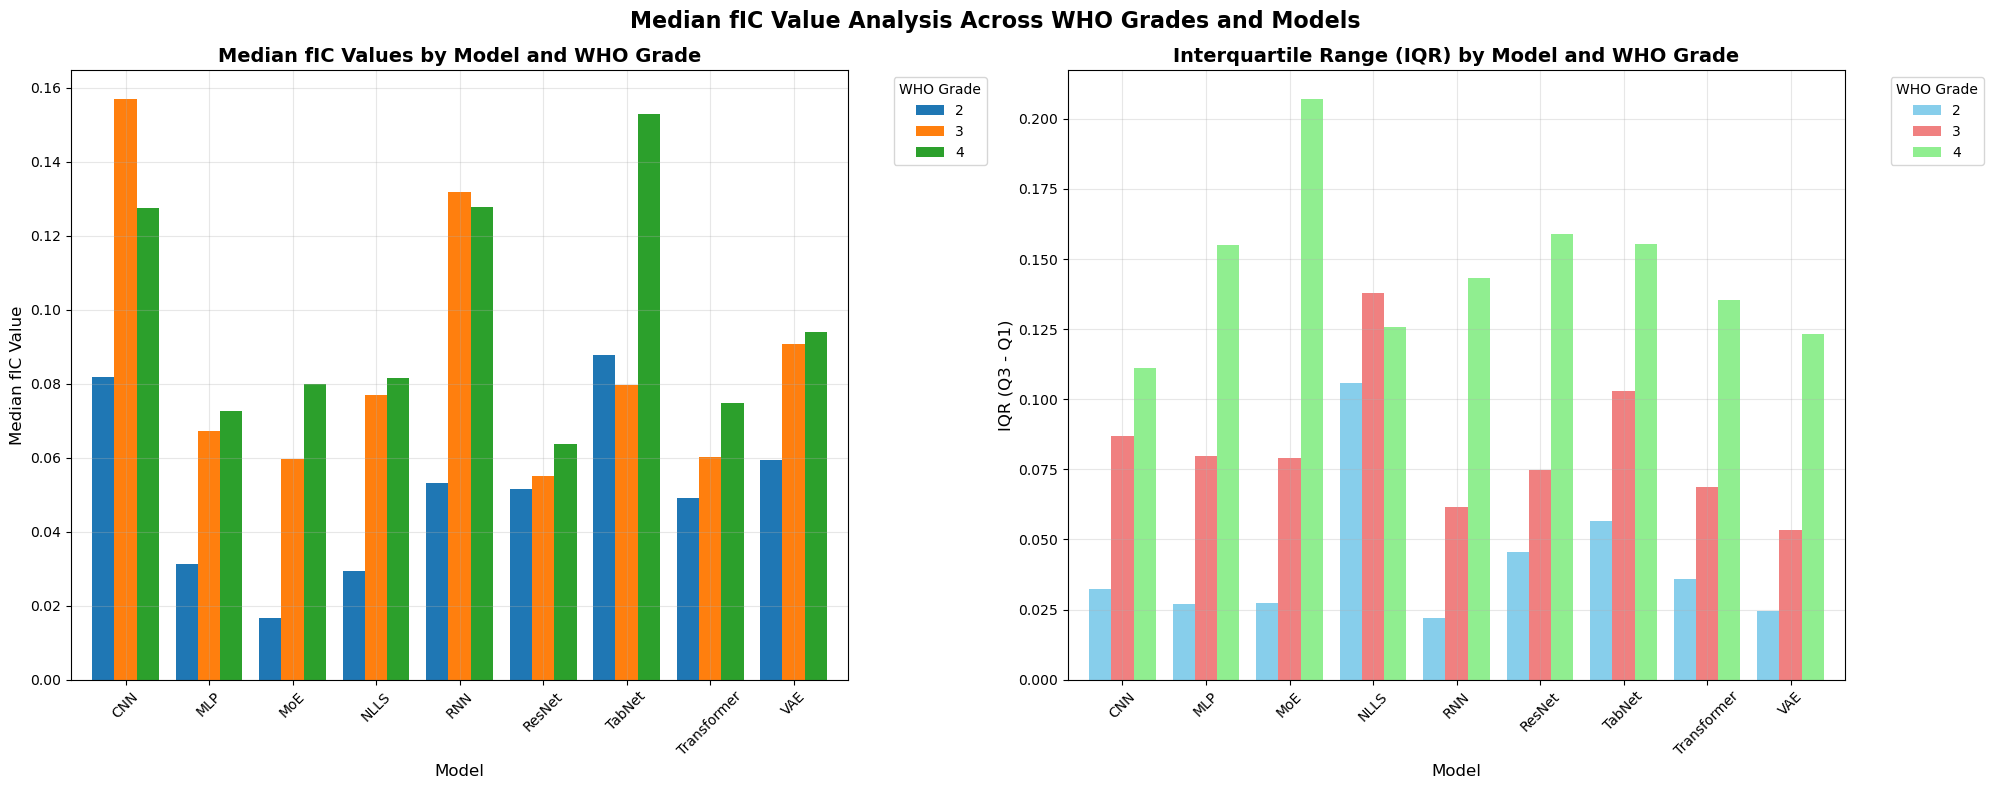



MODEL RANKING BY MEDIAN SEPARATION ABILITY:
Rank  Model           Range    CV       Score   
--------------------------------------------------
1     MoE             0.0632   0.5055   0.0319  
2     RNN             0.0786   0.3466   0.0272  
3     TabNet          0.0732   0.3068   0.0225  
4     NLLS            0.0523   0.3775   0.0197  
5     CNN             0.0751   0.2530   0.0190  
6     MLP             0.0415   0.3222   0.0134  
7     VAE             0.0344   0.1909   0.0066  
8     Transformer     0.0259   0.1724   0.0045  
9     ResNet          0.0119   0.0883   0.0011  

Median analysis completed!
Note: Higher separation score indicates better ability to distinguish between WHO grades using median values.


In [12]:
# MEDIAN ANALYSIS: WHO GRADE COMPARISON
print("Creating median analysis for WHO grade comparison across models...")
print("=" * 60)

# Calculate median statistics for each model and WHO grade
median_analysis_results = []

for model_name in df['model_name'].unique():
    model_data = df[df['model_name'] == model_name]
    
    for grade in sorted(model_data['who_grade'].unique()):
        grade_data = model_data[model_data['who_grade'] == grade]['fic_value']
        
        if len(grade_data) > 0:
            median_val = grade_data.median()
            q1 = grade_data.quantile(0.25)
            q3 = grade_data.quantile(0.75)
            iqr = q3 - q1
            count = len(grade_data)
            
            median_analysis_results.append({
                'model_name': model_name,
                'who_grade': grade,
                'median': median_val,
                'q1': q1,
                'q3': q3,
                'iqr': iqr,
                'count': count
            })

# Convert to DataFrame for easier analysis
df_median = pd.DataFrame(median_analysis_results)

# Display results in a formatted table
print("\nMEDIAN STATISTICS BY MODEL AND WHO GRADE:")
print("=" * 80)
print(f"{'Model':<15} {'Grade':<6} {'Count':<6} {'Median':<8} {'Q1':<8} {'Q3':<8} {'IQR':<8}")
print("-" * 80)

for _, row in df_median.iterrows():
    print(f"{row['model_name']:<15} {row['who_grade']:<6.0f} {row['count']:<6.0f} "
          f"{row['median']:<8.4f} {row['q1']:<8.4f} {row['q3']:<8.4f} {row['iqr']:<8.4f}")

# Calculate median differences between grades for each model
print("\n\nMEDIAN DIFFERENCES BETWEEN WHO GRADES:")
print("=" * 50)

for model_name in df_median['model_name'].unique():
    model_medians = df_median[df_median['model_name'] == model_name]
    print(f"\n{model_name}:")
    
    # Get all unique grade combinations
    grades = sorted(model_medians['who_grade'].unique())
    
    for i in range(len(grades)):
        for j in range(i+1, len(grades)):
            grade1, grade2 = grades[i], grades[j]
            
            median1 = model_medians[model_medians['who_grade'] == grade1]['median'].iloc[0]
            median2 = model_medians[model_medians['who_grade'] == grade2]['median'].iloc[0]
            
            diff = median2 - median1
            pct_change = (diff / median1) * 100 if median1 != 0 else float('inf')
            
            print(f"  Grade {grade1:.0f} vs Grade {grade2:.0f}: {diff:+.4f} ({pct_change:+.1f}%)")

# Create visualization of median values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Median fIC Value Analysis Across WHO Grades and Models', 
             fontsize=16, fontweight='bold')

# Plot 1: Median values by model and grade
pivot_median = df_median.pivot(index='model_name', columns='who_grade', values='median')
pivot_median.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Median fIC Values by Model and WHO Grade', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Median fIC Value', fontsize=12)
ax1.legend(title='WHO Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: IQR (spread) analysis
pivot_iqr = df_median.pivot(index='model_name', columns='who_grade', values='iqr')
pivot_iqr.plot(kind='bar', ax=ax2, width=0.8, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax2.set_title('Interquartile Range (IQR) by Model and WHO Grade', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('IQR (Q3 - Q1)', fontsize=12)
ax2.legend(title='WHO Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Rank models by median separation ability
print("\n\nMODEL RANKING BY MEDIAN SEPARATION ABILITY:")
print("=" * 55)

model_separation_scores = []

for model_name in df_median['model_name'].unique():
    model_medians = df_median[df_median['model_name'] == model_name]
    
    if len(model_medians) > 1:
        # Calculate coefficient of variation of medians across grades
        medians = model_medians['median'].values
        median_std = np.std(medians)
        median_mean = np.mean(medians)
        cv = median_std / median_mean if median_mean != 0 else 0
        
        # Calculate total range of medians
        median_range = np.max(medians) - np.min(medians)
        
        model_separation_scores.append({
            'model_name': model_name,
            'median_range': median_range,
            'coefficient_of_variation': cv,
            'separation_score': median_range * cv  # Combined score
        })

# Sort by separation score (higher is better for distinguishing grades)
model_separation_scores.sort(key=lambda x: x['separation_score'], reverse=True)

print(f"{'Rank':<5} {'Model':<15} {'Range':<8} {'CV':<8} {'Score':<8}")
print("-" * 50)

for i, model_score in enumerate(model_separation_scores, 1):
    print(f"{i:<5} {model_score['model_name']:<15} {model_score['median_range']:<8.4f} "
          f"{model_score['coefficient_of_variation']:<8.4f} {model_score['separation_score']:<8.4f}")

print("\nMedian analysis completed!")
print("Note: Higher separation score indicates better ability to distinguish between WHO grades using median values.")

Creating WHO Grade 2 vs 4 comparison with patient-median fIC values...
Patient-median dataset created with 81 patient-model combinations
Grade 2 patients: 4
Grade 4 patients: 5

Statistical Testing (Patient-Median Data):
CNN         : Grade 2 median=0.0934, Grade 4 median=0.1545
             p-value=0.1111, Cohen's d=1.696 (ns)
MLP         : Grade 2 median=0.0645, Grade 4 median=0.1049
             p-value=0.1905, Cohen's d=0.913 (ns)
ResNet      : Grade 2 median=0.0726, Grade 4 median=0.0938
             p-value=0.5556, Cohen's d=0.557 (ns)
MoE         : Grade 2 median=0.0279, Grade 4 median=0.0666
             p-value=0.7302, Cohen's d=0.432 (ns)
RNN         : Grade 2 median=0.0814, Grade 4 median=0.1471
             p-value=0.4127, Cohen's d=1.359 (ns)
TabNet      : Grade 2 median=0.1051, Grade 4 median=0.1725
             p-value=0.0635, Cohen's d=1.929 (ns)
Transformer : Grade 2 median=0.0762, Grade 4 median=0.1173
             p-value=0.4127, Cohen's d=1.232 (ns)
VAE         : Gr

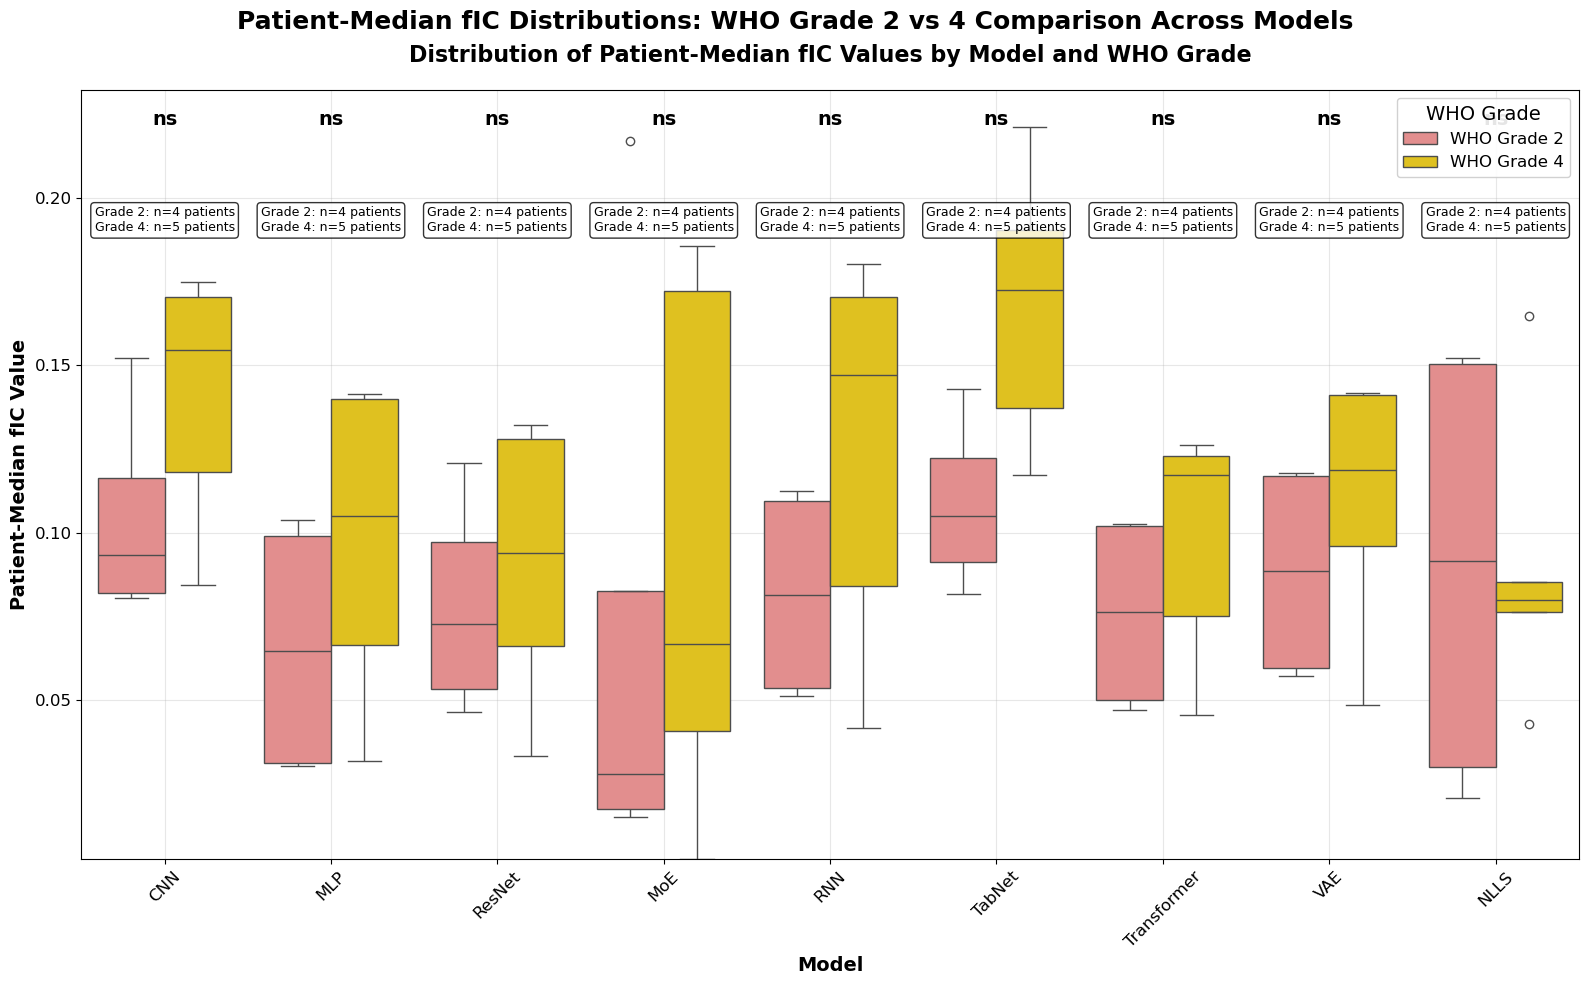


WHO Grade 2 vs 4 patient-median visualization completed!
Note: This analysis uses median fIC values per patient instead of mean values.


In [ ]:
# PATIENT-MEDIAN ANALYSIS: WHO GRADE 2 vs 4 COMPARISON
print("Creating WHO Grade 2 vs 4 comparison with patient-median fIC values...")

# Filter data for WHO grades 2 and 4 only
df_2v4_median = df[df['who_grade'].isin([2, 4])].copy()

if len(df_2v4_median) > 0:
    # Calculate patient-median fIC values for each model
    patient_median_data = []
    
    for model_name in df_2v4_median['model_name'].unique():
        model_data = df_2v4_median[df_2v4_median['model_name'] == model_name]
        
        # Group by patient and calculate median fIC for each patient
        patient_medians = model_data.groupby(['patient_id', 'who_grade'])['fic_value'].median().reset_index()
        
        # Add model name back
        patient_medians['model_name'] = model_name
        patient_median_data.append(patient_medians)
    
    # Combine all patient-median data
    df_patient_median = pd.concat(patient_median_data, ignore_index=True)
    
    print(f"Patient-median dataset created with {len(df_patient_median)} patient-model combinations")
    print(f"Grade 2 patients: {len(df_patient_median[df_patient_median['who_grade'] == 2]['patient_id'].unique())}")
    print(f"Grade 4 patients: {len(df_patient_median[df_patient_median['who_grade'] == 4]['patient_id'].unique())}")
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    fig.suptitle('Patient-Median fIC Distributions: WHO Grade 2 vs 4 Comparison Across Models', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Adjust subplot to leave more space at the top
    plt.subplots_adjust(top=0.85)
    
    # Use seaborn box plot with WHO grade as hue for direct comparison
    sns.boxplot(data=df_patient_median, x='model_name', y='fic_value', hue='who_grade', 
                ax=ax, palette=['lightcoral', 'lightblue'])
    
    # Add individual patient points (jittered)
    sns.stripplot(data=df_patient_median, x='model_name', y='fic_value', hue='who_grade', 
                  ax=ax, size=4, alpha=0.7, dodge=True, palette=['darkred', 'darkblue'])
    
    # Customize the plot
    ax.set_xlabel('Model Architecture', fontsize=14, fontweight='bold')
    ax.set_ylabel('Patient-Median fIC values', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, alpha=0.3)
    
    # Set consistent y-axis limits
    global_min = df_patient_median['fic_value'].min()
    global_max = df_patient_median['fic_value'].max()
    y_margin = (global_max - global_min) * 0.05
    y_lim_2v4_median = (global_min - y_margin, global_max + y_margin)
    ax.set_ylim(y_lim_2v4_median)
    
    # Enhanced legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ['WHO Grade 2', 'WHO Grade 4'], 
              title='WHO Grade', title_fontsize=14, fontsize=12, 
              loc='upper right', framealpha=0.9)
    
    # Add sample size annotations for each model
    for i, model in enumerate([spec['name'] for spec in model_specs]):
        # Grade 2 and 4 data
        grade2_data = df_patient_median[(df_patient_median['model_name'] == model) & (df_patient_median['who_grade'] == 2)]
        grade4_data = df_patient_median[(df_patient_median['model_name'] == model) & (df_patient_median['who_grade'] == 4)]
        
        annotation_text = ""
        if not grade2_data.empty:
            grade2_patients = len(grade2_data)
            annotation_text += f'Grade 2: n={grade2_patients} patients'
            
        if not grade4_data.empty:
            grade4_patients = len(grade4_data)
            if annotation_text:
                annotation_text += f'\nGrade 4: n={grade4_patients} patients'
            else:
                annotation_text = f'Grade 4: n={grade4_patients} patients'
        
        # Add annotation above each model
        if annotation_text:
            ax.text(i, y_lim_2v4_median[1] * 0.85, annotation_text,
                   ha='center', va='top', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add statistical significance indicators (Mann-Whitney U test for patient medians)
    try:
        from scipy.stats import mannwhitneyu
        
        print("\nStatistical Testing (Patient-Median Data):")
        print("=" * 50)
        
        for i, model in enumerate([spec['name'] for spec in model_specs]):
            df_model = df_patient_median[df_patient_median['model_name'] == model]
            grade2_data = df_model[df_model['who_grade'] == 2]['fic_value']
            grade4_data = df_model[df_model['who_grade'] == 4]['fic_value']
            
            if len(grade2_data) > 1 and len(grade4_data) > 1:  # Need at least 2 patients per group
                _, p_value = mannwhitneyu(grade2_data, grade4_data, alternative='two-sided')
                
                # Add significance stars
                if p_value < 0.001:
                    sig_text = "***"
                elif p_value < 0.01:
                    sig_text = "**" 
                elif p_value < 0.05:
                    sig_text = "*"
                else:
                    sig_text = "ns"
                
                # Calculate effect size (Cohen's d for median comparison)
                grade2_median = grade2_data.median()
                grade4_median = grade4_data.median()
                pooled_std = np.sqrt((grade2_data.var() + grade4_data.var()) / 2)
                cohens_d = (grade4_median - grade2_median) / pooled_std if pooled_std != 0 else 0
                
                # Add significance annotation to plot
                y_pos = y_lim_2v4_median[1] * 0.95
                ax.text(i, y_pos, sig_text, ha='center', va='bottom', fontsize=14, fontweight='bold')
                
                # Print detailed statistics
                print(f"{model:12}: Grade 2 median={grade2_median:.4f}, Grade 4 median={grade4_median:.4f}")
                print(f"             p-value={p_value:.4f}, Cohen's d={cohens_d:.3f} ({sig_text})")
                
            else:
                print(f"{model:12}: Insufficient data for statistical testing")
    
    except ImportError:
        print("scipy not available for statistical testing")
    
    # Print summary statistics for patient-median data
    print(f"\nSummary Statistics (Patient-Median Analysis):")
    print("=" * 55)
    
    for model in [spec['name'] for spec in model_specs]:
        df_model = df_patient_median[df_patient_median['model_name'] == model]
        
        grade2_stats = ""
        grade4_stats = ""
        
        try:
            grade2_data = df_model[df_model['who_grade'] == 2]['fic_value']
            if not grade2_data.empty:
                grade2_median = grade2_data.median()
                grade2_q1 = grade2_data.quantile(0.25)
                grade2_q3 = grade2_data.quantile(0.75)
                grade2_patients = len(grade2_data)
                grade2_stats = f"Grade 2: median={grade2_median:.4f} (Q1={grade2_q1:.4f}, Q3={grade2_q3:.4f}, n={grade2_patients})"
        except KeyError:
            pass
            
        try:
            grade4_data = df_model[df_model['who_grade'] == 4]['fic_value']
            if not grade4_data.empty:
                grade4_median = grade4_data.median()
                grade4_q1 = grade4_data.quantile(0.25)
                grade4_q3 = grade4_data.quantile(0.75)
                grade4_patients = len(grade4_data)
                grade4_stats = f"Grade 4: median={grade4_median:.4f} (Q1={grade4_q1:.4f}, Q3={grade4_q3:.4f}, n={grade4_patients})"
        except KeyError:
            pass
        
        if grade2_stats or grade4_stats:
            comparison_text = ", ".join(filter(None, [grade2_stats, grade4_stats]))
            print(f"{model:12}: {comparison_text}")
        else:
            print(f"{model:12}: No data available")
    
    # Layout and display
    plt.tight_layout()
    plt.show()

    print("\nWHO Grade 2 vs 4 patient-median visualization completed!")
    print("Note: This analysis uses median fIC values per patient instead of mean values.")
else:
    print("No data available for WHO Grade 2 vs 4 patient-median comparison")

Creating WHO Grade 2 vs 3 comparison visualization...


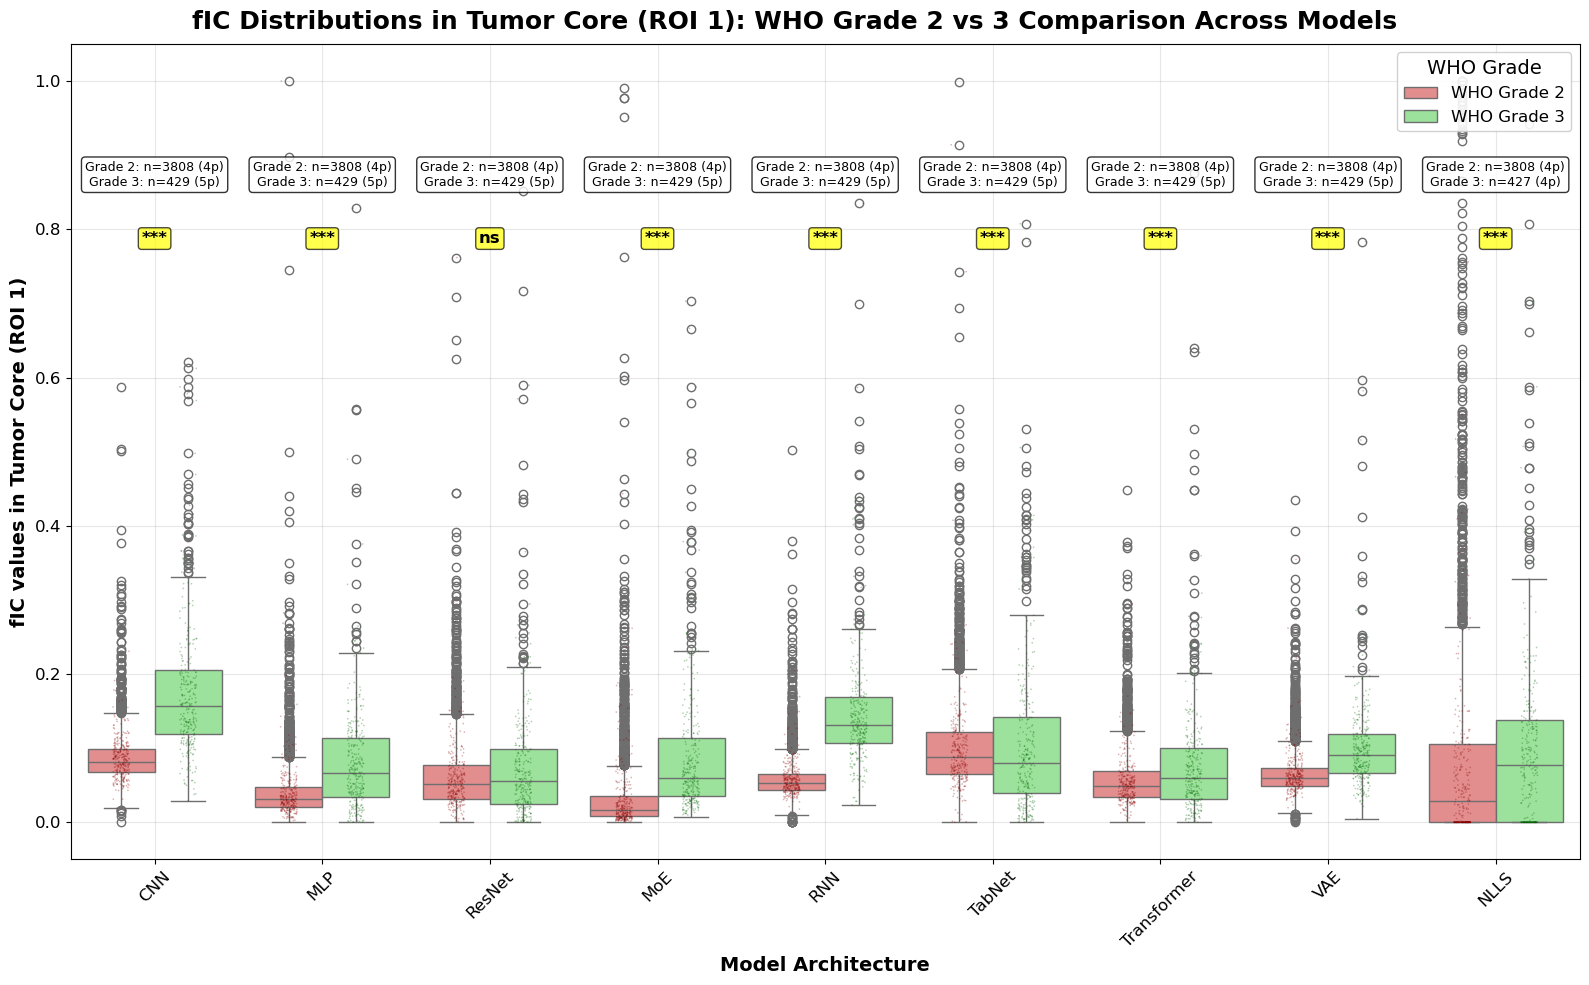


WHO Grade 2 vs 3 Visualization Summary:
Y-axis range: [-0.050, 1.050]
Statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant

Quick Grade 2 vs 3 Comparison (Mean fIC ± SD):
CNN         : Grade 2 = 0.087±0.034, Grade 3 = 0.178±0.096
MLP         : Grade 2 = 0.041±0.044, Grade 3 = 0.084±0.082
ResNet      : Grade 2 = 0.061±0.050, Grade 3 = 0.078±0.093
MoE         : Grade 2 = 0.032±0.056, Grade 3 = 0.092±0.097
RNN         : Grade 2 = 0.059±0.029, Grade 3 = 0.151±0.090
TabNet      : Grade 2 = 0.101±0.062, Grade 3 = 0.110±0.110
Transformer : Grade 2 = 0.057±0.038, Grade 3 = 0.082±0.092
VAE         : Grade 2 = 0.066±0.031, Grade 3 = 0.104±0.074
NLLS        : Grade 2 = 0.078±0.138, Grade 3 = 0.102±0.127

WHO Grade 2 vs 3 visualization completed!


In [14]:
# UNIFIED VISUALIZATION: WHO GRADE 2 vs 3 COMPARISON
print("Creating WHO Grade 2 vs 3 comparison visualization...")

# Filter data for WHO grades 2 and 3 only
df_2v3 = df[df['who_grade'].isin([2, 3])].copy()

if len(df_2v3) > 0:
    # Create a single comprehensive figure with better spacing
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    fig.suptitle('fIC Distributions in Tumor Core (ROI 1): WHO Grade 2 vs 3 Comparison Across Models', 
                 fontsize=18, fontweight='bold', y=0.98)

    # Adjust subplot to leave more space at the top
    plt.subplots_adjust(top=0.85)

    # Use seaborn box plot with WHO grade as hue for direct comparison
    # Grade 2 = red, Grade 3 = green for consistency
    sns.boxplot(data=df_2v3, x='model_name', y='fic_value', hue='who_grade', 
                ax=ax, palette=['lightcoral', 'lightgreen'])

    # Add jittered points (subsample for clarity)
    df_sub_2v3 = df_2v3.groupby(['model_name', 'who_grade']).apply(
        lambda x: x.sample(min(300, len(x)), random_state=42),
        include_groups=False
    ).reset_index()

    # Fix the column structure after groupby
    df_sub_2v3 = df_sub_2v3.drop(columns=['level_2']) if 'level_2' in df_sub_2v3.columns else df_sub_2v3

    sns.stripplot(data=df_sub_2v3, x='model_name', y='fic_value', hue='who_grade', 
                  ax=ax, size=1.2, alpha=0.3, dodge=True, palette=['darkred', 'darkgreen'])

    # Customize the plot
    ax.set_xlabel('Model Architecture', fontsize=14, fontweight='bold')
    ax.set_ylabel('fIC values in Tumor Core (ROI 1)', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, alpha=0.3)

    # Set consistent y-axis limits
    global_min_2v3 = df_2v3['fic_value'].min()
    global_max_2v3 = df_2v3['fic_value'].max()
    y_margin_2v3 = (global_max_2v3 - global_min_2v3) * 0.05
    y_lim_2v3 = (global_min_2v3 - y_margin_2v3, global_max_2v3 + y_margin_2v3)
    ax.set_ylim(y_lim_2v3)

    # Enhanced legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ['WHO Grade 2', 'WHO Grade 3'], 
              title='WHO Grade', title_fontsize=14, fontsize=12, 
              loc='upper right', framealpha=0.9)

    # Add sample size annotations for each model
    for i, model in enumerate([spec['name'] for spec in model_specs]):
        # Grade 2 and 3 data
        grade2_data = df_2v3[(df_2v3['model_name'] == model) & (df_2v3['who_grade'] == 2)]
        grade3_data = df_2v3[(df_2v3['model_name'] == model) & (df_2v3['who_grade'] == 3)]
        
        annotation_text = ""
        if not grade2_data.empty:
            grade2_patients = grade2_data['patient_id'].nunique()
            grade2_voxels = len(grade2_data)
            annotation_text += f'Grade 2: n={grade2_voxels} ({grade2_patients}p)'
            
        if not grade3_data.empty:
            grade3_patients = grade3_data['patient_id'].nunique()
            grade3_voxels = len(grade3_data)
            if annotation_text:
                annotation_text += f'\nGrade 3: n={grade3_voxels} ({grade3_patients}p)'
            else:
                annotation_text = f'Grade 3: n={grade3_voxels} ({grade3_patients}p)'
        
        # Add annotation above each model
        if annotation_text:
            ax.text(i, y_lim_2v3[1] * 0.85, annotation_text,
                   ha='center', va='top', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Add statistical significance indicators
    try:
        from scipy.stats import mannwhitneyu
        
        for i, model in enumerate([spec['name'] for spec in model_specs]):
            df_model = df_2v3[df_2v3['model_name'] == model]
            grade2_data = df_model[df_model['who_grade'] == 2]['fic_value']
            grade3_data = df_model[df_model['who_grade'] == 3]['fic_value']
            
            if len(grade2_data) > 0 and len(grade3_data) > 0:
                _, p_value = mannwhitneyu(grade2_data, grade3_data, alternative='two-sided')
                
                # Add significance stars
                if p_value < 0.001:
                    sig_text = "***"
                elif p_value < 0.01:
                    sig_text = "**" 
                elif p_value < 0.05:
                    sig_text = "*"
                else:
                    sig_text = "ns"
                
                ax.text(i, y_lim_2v3[1] * 0.75, sig_text, 
                       ha='center', va='center', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))

    except ImportError:
        pass

    plt.tight_layout()
    plt.show()

    # Print summary comparison
    print("\nWHO Grade 2 vs 3 Visualization Summary:")
    print(f"Y-axis range: [{y_lim_2v3[0]:.3f}, {y_lim_2v3[1]:.3f}]")
    print("Statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

    # Summary statistics comparison
    grade_comparison_2v3 = df_2v3.groupby(['who_grade', 'model_name'])['fic_value'].agg([
        'mean', 'std', 'count'
    ]).round(4)

    print("\nQuick Grade 2 vs 3 Comparison (Mean fIC ± SD):")
    for model in [spec['name'] for spec in model_specs]:
        grade2_stats = ""
        grade3_stats = ""
        
        try:
            if (2, model) in grade_comparison_2v3.index:
                grade2_mean = grade_comparison_2v3.loc[(2, model), 'mean']
                grade2_std = grade_comparison_2v3.loc[(2, model), 'std']
                grade2_stats = f"Grade 2 = {grade2_mean:.3f}±{grade2_std:.3f}"
        except KeyError:
            pass
            
        try:
            if (3, model) in grade_comparison_2v3.index:
                grade3_mean = grade_comparison_2v3.loc[(3, model), 'mean'] 
                grade3_std = grade_comparison_2v3.loc[(3, model), 'std']
                grade3_stats = f"Grade 3 = {grade3_mean:.3f}±{grade3_std:.3f}"
        except KeyError:
            pass
        
        if grade2_stats or grade3_stats:
            comparison_text = ", ".join(filter(None, [grade2_stats, grade3_stats]))
            print(f"{model:12}: {comparison_text}")
        else:
            print(f"{model:12}: No data available")

    print("\nWHO Grade 2 vs 3 visualization completed!")
else:
    print("No data available for WHO Grade 2 vs 3 comparison")

Creating WHO Grade 3 vs 4 comparison visualization...


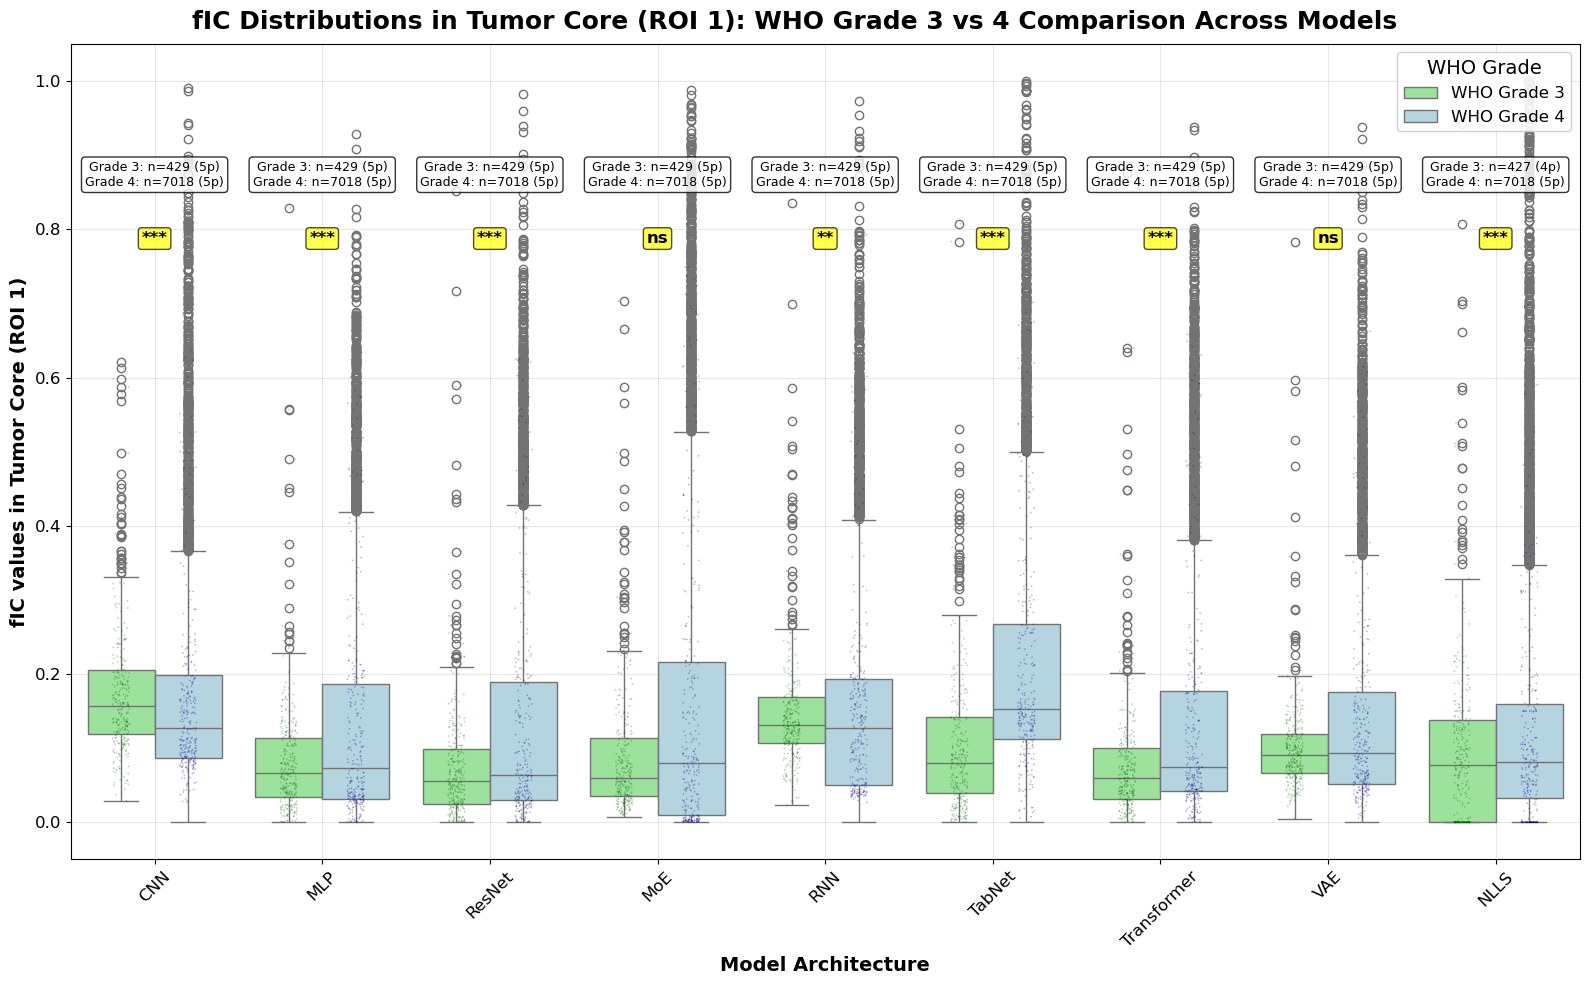


WHO Grade 3 vs 4 Visualization Summary:
Y-axis range: [-0.050, 1.050]
Statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant

Quick Grade 3 vs 4 Comparison (Mean fIC ± SD):
CNN         : Grade 3 = 0.178±0.096, Grade 4 = 0.170±0.133
MLP         : Grade 3 = 0.084±0.082, Grade 4 = 0.131±0.143
ResNet      : Grade 3 = 0.078±0.093, Grade 4 = 0.135±0.157
MoE         : Grade 3 = 0.092±0.097, Grade 4 = 0.158±0.201
RNN         : Grade 3 = 0.151±0.090, Grade 4 = 0.159±0.139
TabNet      : Grade 3 = 0.110±0.110, Grade 4 = 0.208±0.157
Transformer : Grade 3 = 0.082±0.092, Grade 4 = 0.139±0.152
VAE         : Grade 3 = 0.104±0.074, Grade 4 = 0.141±0.133
NLLS        : Grade 3 = 0.102±0.127, Grade 4 = 0.144±0.190

WHO Grade 3 vs 4 visualization completed!


In [15]:
# UNIFIED VISUALIZATION: WHO GRADE 3 vs 4 COMPARISON
print("Creating WHO Grade 3 vs 4 comparison visualization...")

# Filter data for WHO grades 3 and 4 only
df_3v4 = df[df['who_grade'].isin([3, 4])].copy()

if len(df_3v4) > 0:
    # Create a single comprehensive figure with better spacing
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    fig.suptitle('fIC Distributions in Tumor Core (ROI 1): WHO Grade 3 vs 4 Comparison Across Models', 
                 fontsize=18, fontweight='bold', y=0.98)

    # Adjust subplot to leave more space at the top
    plt.subplots_adjust(top=0.85)

    # Use seaborn box plot with WHO grade as hue for direct comparison
    # Grade 3 = green for consistency
    sns.boxplot(data=df_3v4, x='model_name', y='fic_value', hue='who_grade', 
                ax=ax, palette=['lightgreen', 'lightblue'])

    # Add jittered points (subsample for clarity)
    df_sub_3v4 = df_3v4.groupby(['model_name', 'who_grade']).apply(
        lambda x: x.sample(min(300, len(x)), random_state=42),
        include_groups=False
    ).reset_index()

    # Fix the column structure after groupby
    df_sub_3v4 = df_sub_3v4.drop(columns=['level_2']) if 'level_2' in df_sub_3v4.columns else df_sub_3v4

    sns.stripplot(data=df_sub_3v4, x='model_name', y='fic_value', hue='who_grade', 
                  ax=ax, size=1.2, alpha=0.3, dodge=True, palette=['darkgreen', 'darkblue'])

    # Customize the plot
    ax.set_xlabel('Model Architecture', fontsize=14, fontweight='bold')
    ax.set_ylabel('fIC values in Tumor Core (ROI 1)', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, alpha=0.3)

    # Set consistent y-axis limits
    global_min_3v4 = df_3v4['fic_value'].min()
    global_max_3v4 = df_3v4['fic_value'].max()
    y_margin_3v4 = (global_max_3v4 - global_min_3v4) * 0.05
    y_lim_3v4 = (global_min_3v4 - y_margin_3v4, global_max_3v4 + y_margin_3v4)
    ax.set_ylim(y_lim_3v4)

    # Enhanced legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ['WHO Grade 3', 'WHO Grade 4'], 
              title='WHO Grade', title_fontsize=14, fontsize=12, 
              loc='upper right', framealpha=0.9)

    # Add sample size annotations for each model
    for i, model in enumerate([spec['name'] for spec in model_specs]):
        # Grade 3 and 4 data
        grade3_data = df_3v4[(df_3v4['model_name'] == model) & (df_3v4['who_grade'] == 3)]
        grade4_data = df_3v4[(df_3v4['model_name'] == model) & (df_3v4['who_grade'] == 4)]
        
        annotation_text = ""
        if not grade3_data.empty:
            grade3_patients = grade3_data['patient_id'].nunique()
            grade3_voxels = len(grade3_data)
            annotation_text += f'Grade 3: n={grade3_voxels} ({grade3_patients}p)'
            
        if not grade4_data.empty:
            grade4_patients = grade4_data['patient_id'].nunique()
            grade4_voxels = len(grade4_data)
            if annotation_text:
                annotation_text += f'\nGrade 4: n={grade4_voxels} ({grade4_patients}p)'
            else:
                annotation_text = f'Grade 4: n={grade4_voxels} ({grade4_patients}p)'
        
        # Add annotation above each model
        if annotation_text:
            ax.text(i, y_lim_3v4[1] * 0.85, annotation_text,
                   ha='center', va='top', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Add statistical significance indicators
    try:
        from scipy.stats import mannwhitneyu
        
        for i, model in enumerate([spec['name'] for spec in model_specs]):
            df_model = df_3v4[df_3v4['model_name'] == model]
            grade3_data = df_model[df_model['who_grade'] == 3]['fic_value']
            grade4_data = df_model[df_model['who_grade'] == 4]['fic_value']
            
            if len(grade3_data) > 0 and len(grade4_data) > 0:
                _, p_value = mannwhitneyu(grade3_data, grade4_data, alternative='two-sided')
                
                # Add significance stars
                if p_value < 0.001:
                    sig_text = "***"
                elif p_value < 0.01:
                    sig_text = "**" 
                elif p_value < 0.05:
                    sig_text = "*"
                else:
                    sig_text = "ns"
                
                ax.text(i, y_lim_3v4[1] * 0.75, sig_text, 
                       ha='center', va='center', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))

    except ImportError:
        pass

    plt.tight_layout()
    plt.show()

    # Print summary comparison
    print("\nWHO Grade 3 vs 4 Visualization Summary:")
    print(f"Y-axis range: [{y_lim_3v4[0]:.3f}, {y_lim_3v4[1]:.3f}]")
    print("Statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

    # Summary statistics comparison
    grade_comparison_3v4 = df_3v4.groupby(['who_grade', 'model_name'])['fic_value'].agg([
        'mean', 'std', 'count'
    ]).round(4)

    print("\nQuick Grade 3 vs 4 Comparison (Mean fIC ± SD):")
    for model in [spec['name'] for spec in model_specs]:
        grade3_stats = ""
        grade4_stats = ""
        
        try:
            if (3, model) in grade_comparison_3v4.index:
                grade3_mean = grade_comparison_3v4.loc[(3, model), 'mean']
                grade3_std = grade_comparison_3v4.loc[(3, model), 'std']
                grade3_stats = f"Grade 3 = {grade3_mean:.3f}±{grade3_std:.3f}"
        except KeyError:
            pass
            
        try:
            if (4, model) in grade_comparison_3v4.index:
                grade4_mean = grade_comparison_3v4.loc[(4, model), 'mean'] 
                grade4_std = grade_comparison_3v4.loc[(4, model), 'std']
                grade4_stats = f"Grade 4 = {grade4_mean:.3f}±{grade4_std:.3f}"
        except KeyError:
            pass
        
        if grade3_stats or grade4_stats:
            comparison_text = ", ".join(filter(None, [grade3_stats, grade4_stats]))
            print(f"{model:12}: {comparison_text}")
        else:
            print(f"{model:12}: No data available")

    print("\nWHO Grade 3 vs 4 visualization completed!")
else:
    print("No data available for WHO Grade 3 vs 4 comparison")

In [16]:
# STATISTICAL ANALYSIS AND PATIENT-LEVEL SUMMARY
print("=" * 80)
print("STATISTICAL ANALYSIS")
print("=" * 80)

# Patient-level analysis (mean fIC per patient per model)
print("Creating patient-level summary...")
patient_summary = df.groupby(['patient_id', 'who_grade', 'model_name'])['fic_value'].agg([
    'mean', 'std', 'count'
]).reset_index()

print("\nPatient-level fIC summary (mean ± std per patient):")
for patient_id in sorted(df['patient_id'].unique()):
    patient_data_summary = patient_summary[patient_summary['patient_id'] == patient_id]
    if not patient_data_summary.empty:
        who_grade = patient_data_summary['who_grade'].iloc[0]
        print(f"\n{patient_id} (WHO Grade {who_grade}):")
        for _, row in patient_data_summary.iterrows():
            print(f"  {row['model_name']:12}: {row['mean']:.3f} ± {row['std']:.3f} "
                  f"(n={row['count']} voxels)")

# Model comparison across WHO grades
print("\n" + "="*50)
print("MODEL COMPARISON ACROSS WHO GRADES")
print("="*50)

model_grade_comparison = df.groupby(['model_name', 'who_grade'])['fic_value'].agg([
    'mean', 'std', 'count'
]).reset_index()

print("\nMean fIC by Model and WHO Grade:")
pivot_mean = model_grade_comparison.pivot(index='model_name', columns='who_grade', values='mean')
print(pivot_mean.round(4))

print("\nStandard Deviation by Model and WHO Grade:")
pivot_std = model_grade_comparison.pivot(index='model_name', columns='who_grade', values='std')
print(pivot_std.round(4))

print("\nVoxel Count by Model and WHO Grade:")
pivot_count = model_grade_comparison.pivot(index='model_name', columns='who_grade', values='count')
print(pivot_count)

# Statistical significance testing (if sufficient data)
try:
    from scipy.stats import mannwhitneyu
    
    print("\n" + "="*50)
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("="*50)
    print("Mann-Whitney U test comparing WHO Grade 2 vs 4 for each model:")
    
    for model in [spec['name'] for spec in model_specs]:
        df_model = df[df['model_name'] == model]
        grade2_data = df_model[df_model['who_grade'] == 2]['fic_value']
        grade4_data = df_model[df_model['who_grade'] == 4]['fic_value']
        
        if len(grade2_data) > 0 and len(grade4_data) > 0:
            statistic, p_value = mannwhitneyu(grade2_data, grade4_data, alternative='two-sided')
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            
            print(f"{model:12}: U={statistic:8.1f}, p={p_value:.4f} {significance:3}")
            print(f"             Grade 2: {grade2_data.mean():.3f} ± {grade2_data.std():.3f} (n={len(grade2_data)})")
            print(f"             Grade 4: {grade4_data.mean():.3f} ± {grade4_data.std():.3f} (n={len(grade4_data)})")
        else:
            print(f"{model:12}: Insufficient data for comparison")
            
except ImportError:
    print("\nSciPy not available for statistical testing")

print("\nAnalysis completed successfully!")

STATISTICAL ANALYSIS
Creating patient-level summary...

Patient-level fIC summary (mean ± std per patient):

Patient01 (WHO Grade 3):
  CNN         : 0.158 ± 0.077 (n=47 voxels)
  MLP         : 0.131 ± 0.069 (n=47 voxels)
  MoE         : 0.134 ± 0.120 (n=47 voxels)
  NLLS        : 0.068 ± 0.057 (n=47 voxels)
  RNN         : 0.147 ± 0.052 (n=47 voxels)
  ResNet      : 0.134 ± 0.083 (n=47 voxels)
  TabNet      : 0.194 ± 0.112 (n=47 voxels)
  Transformer : 0.133 ± 0.075 (n=47 voxels)
  VAE         : 0.147 ± 0.061 (n=47 voxels)

Patient02 (WHO Grade 3):
  CNN         : 0.239 ± 0.087 (n=31 voxels)
  MLP         : 0.082 ± 0.062 (n=31 voxels)
  MoE         : 0.174 ± 0.083 (n=31 voxels)
  NLLS        : 0.248 ± 0.271 (n=31 voxels)
  RNN         : 0.162 ± 0.065 (n=31 voxels)
  ResNet      : 0.072 ± 0.061 (n=31 voxels)
  TabNet      : 0.138 ± 0.101 (n=31 voxels)
  Transformer : 0.073 ± 0.054 (n=31 voxels)
  VAE         : 0.090 ± 0.051 (n=31 voxels)

Patient03 (WHO Grade 4):
  CNN         : 0.241 

In [17]:
# EFFECT SIZE ANALYSIS
print("=" * 80)
print("EFFECT SIZE ANALYSIS")
print("=" * 80)

# Effect size calculation functions
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    if n1 == 0 or n2 == 0:
        return np.nan
    
    # Calculate means
    m1, m2 = np.mean(group1), np.mean(group2)
    
    # Calculate pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * np.var(group1, ddof=1) + (n2 - 1) * np.var(group2, ddof=1)) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        return np.nan
    
    return (m1 - m2) / pooled_std

def glass_delta(group1, group2, control_group=2):
    """Calculate Glass's delta (uses control group SD)"""
    if len(group1) == 0 or len(group2) == 0:
        return np.nan
    
    m1, m2 = np.mean(group1), np.mean(group2)
    
    # Use control group (usually the lower grade) standard deviation
    if control_group == 1:
        control_std = np.std(group1, ddof=1)
    else:
        control_std = np.std(group2, ddof=1)
    
    if control_std == 0:
        return np.nan
    
    return (m1 - m2) / control_std

def cliffs_delta(group1, group2):
    """Calculate Cliff's delta (non-parametric effect size)"""
    if len(group1) == 0 or len(group2) == 0:
        return np.nan
    
    # Create all pairwise comparisons
    n1, n2 = len(group1), len(group2)
    dominance = 0
    
    for x1 in group1:
        for x2 in group2:
            if x1 > x2:
                dominance += 1
            elif x1 < x2:
                dominance -= 1
    
    return dominance / (n1 * n2)

def interpret_effect_size(value, metric='cohens_d'):
    """Interpret effect size magnitude"""
    abs_value = abs(value)
    
    if metric == 'cohens_d':
        if abs_value < 0.2:
            return "negligible"
        elif abs_value < 0.5:
            return "small"
        elif abs_value < 0.8:
            return "medium"
        else:
            return "large"
    elif metric == 'cliffs_delta':
        if abs_value < 0.147:
            return "negligible"
        elif abs_value < 0.33:
            return "small"
        elif abs_value < 0.474:
            return "medium"
        else:
            return "large"
    else:  # glass_delta
        return interpret_effect_size(value, 'cohens_d')  # Same thresholds as Cohen's d

print("Effect size functions defined successfully.")
print("Interpretation thresholds:")
print("  Cohen's d / Glass's Δ: negligible (<0.2), small (0.2-0.5), medium (0.5-0.8), large (≥0.8)")
print("  Cliff's δ: negligible (<0.147), small (0.147-0.33), medium (0.33-0.474), large (≥0.474)")

EFFECT SIZE ANALYSIS
Effect size functions defined successfully.
Interpretation thresholds:
  Cohen's d / Glass's Δ: negligible (<0.2), small (0.2-0.5), medium (0.5-0.8), large (≥0.8)
  Cliff's δ: negligible (<0.147), small (0.147-0.33), medium (0.33-0.474), large (≥0.474)


In [18]:
# COMPREHENSIVE EFFECT SIZE CALCULATIONS
print("\n" + "="*60)
print("EFFECT SIZE ANALYSIS: WHO GRADE COMPARISONS")
print("="*60)

# Create comprehensive effect size comparison table
effect_size_results = []

# Define grade comparisons
grade_comparisons = [
    (2, 3, "Grade 2 vs 3"),
    (2, 4, "Grade 2 vs 4"), 
    (3, 4, "Grade 3 vs 4")
]

for grade1, grade2, comparison_name in grade_comparisons:
    print(f"\n{comparison_name} Comparison:")
    print("-" * 40)
    
    for model in [spec['name'] for spec in model_specs]:
        # Get data for each grade
        df_model = df[df['model_name'] == model]
        grade1_data = df_model[df_model['who_grade'] == grade1]['fic_value'].values
        grade2_data = df_model[df_model['who_grade'] == grade2]['fic_value'].values
        
        if len(grade1_data) > 0 and len(grade2_data) > 0:
            # Calculate effect sizes
            cohens = cohens_d(grade1_data, grade2_data)
            glass = glass_delta(grade1_data, grade2_data, control_group=1)  # Use lower grade as control
            cliffs = cliffs_delta(grade1_data, grade2_data)
            
            # Store results
            effect_size_results.append({
                'comparison': comparison_name,
                'model': model,
                'grade1': grade1,
                'grade2': grade2,
                'n1': len(grade1_data),
                'n2': len(grade2_data),
                'mean1': np.mean(grade1_data),
                'mean2': np.mean(grade2_data),
                'cohens_d': cohens,
                'glass_delta': glass,
                'cliffs_delta': cliffs,
                'cohens_interpretation': interpret_effect_size(cohens, 'cohens_d'),
                'glass_interpretation': interpret_effect_size(glass, 'glass_delta'),
                'cliffs_interpretation': interpret_effect_size(cliffs, 'cliffs_delta')
            })
            
            # Print formatted results
            print(f"{model:12}: Cohen's d = {cohens:7.3f} ({interpret_effect_size(cohens, 'cohens_d'):10}), "
                  f"Glass's Δ = {glass:7.3f} ({interpret_effect_size(glass, 'glass_delta'):10}), "
                  f"Cliff's δ = {cliffs:7.3f} ({interpret_effect_size(cliffs, 'cliffs_delta'):10})")
            print(f"             Grade {grade1}: μ={np.mean(grade1_data):.3f} (n={len(grade1_data):4}), "
                  f"Grade {grade2}: μ={np.mean(grade2_data):.3f} (n={len(grade2_data):4})")
        else:
            print(f"{model:12}: Insufficient data for comparison")

# Convert to DataFrame for easier analysis
effect_size_df = pd.DataFrame(effect_size_results)

print(f"\nEffect size analysis completed for {len(effect_size_results)} model-comparison pairs")


EFFECT SIZE ANALYSIS: WHO GRADE COMPARISONS

Grade 2 vs 3 Comparison:
----------------------------------------
CNN         : Cohen's d =  -2.060 (large     ), Glass's Δ =  -2.692 (large     ), Cliff's δ =  -0.755 (large     )
             Grade 2: μ=0.087 (n=3808), Grade 3: μ=0.178 (n= 429)
CNN         : Cohen's d =  -2.060 (large     ), Glass's Δ =  -2.692 (large     ), Cliff's δ =  -0.755 (large     )
             Grade 2: μ=0.087 (n=3808), Grade 3: μ=0.178 (n= 429)
MLP         : Cohen's d =  -0.862 (large     ), Glass's Δ =  -0.965 (large     ), Cliff's δ =  -0.425 (medium    )
             Grade 2: μ=0.041 (n=3808), Grade 3: μ=0.083 (n= 429)
MLP         : Cohen's d =  -0.862 (large     ), Glass's Δ =  -0.965 (large     ), Cliff's δ =  -0.425 (medium    )
             Grade 2: μ=0.041 (n=3808), Grade 3: μ=0.083 (n= 429)
ResNet      : Cohen's d =  -0.306 (small     ), Glass's Δ =  -0.343 (small     ), Cliff's δ =  -0.035 (negligible)
             Grade 2: μ=0.061 (n=3808), Grade 3: 


EFFECT SIZE SUMMARY TABLES

COHEN'S D BY COMPARISON AND MODEL:
comparison   Grade 2 vs 3  Grade 2 vs 4  Grade 3 vs 4
model                                                
CNN                -2.060        -0.767         0.061
MLP                -0.862        -0.759        -0.338
MoE                -0.980        -0.761        -0.335
NLLS               -0.172        -0.377        -0.224
RNN                -2.334        -0.881        -0.057
ResNet             -0.306        -0.567        -0.367
TabNet             -0.134        -0.815        -0.635
Transformer        -0.548        -0.658        -0.378
VAE                -0.994        -0.687        -0.285

GLASS'S DELTA BY COMPARISON AND MODEL:
comparison   Grade 2 vs 3  Grade 2 vs 4  Grade 3 vs 4
model                                                
CNN                -2.692        -2.456         0.083
MLP                -0.965        -2.048        -0.577
MoE                -1.074        -2.252        -0.681
NLLS               -0.171       

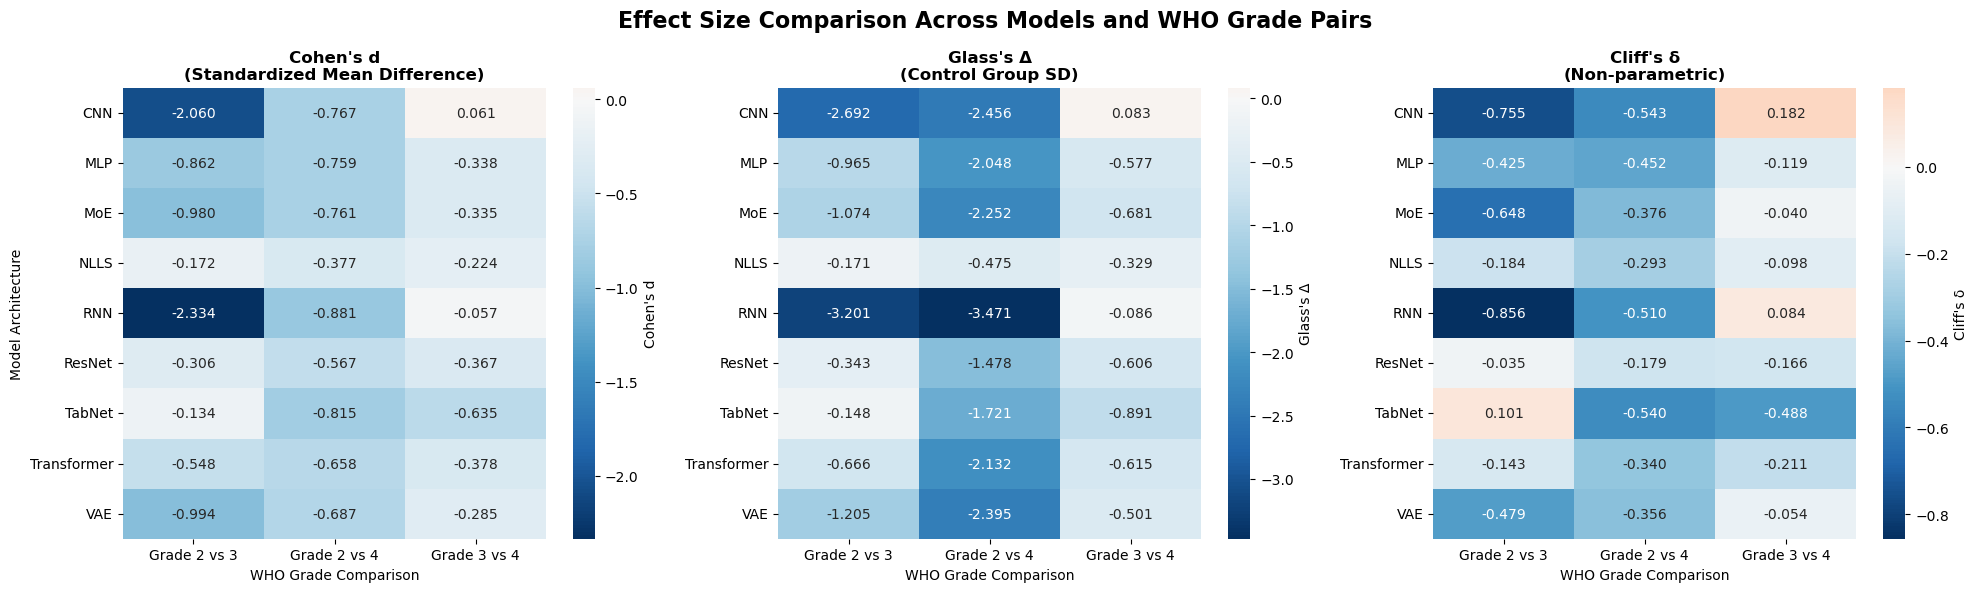

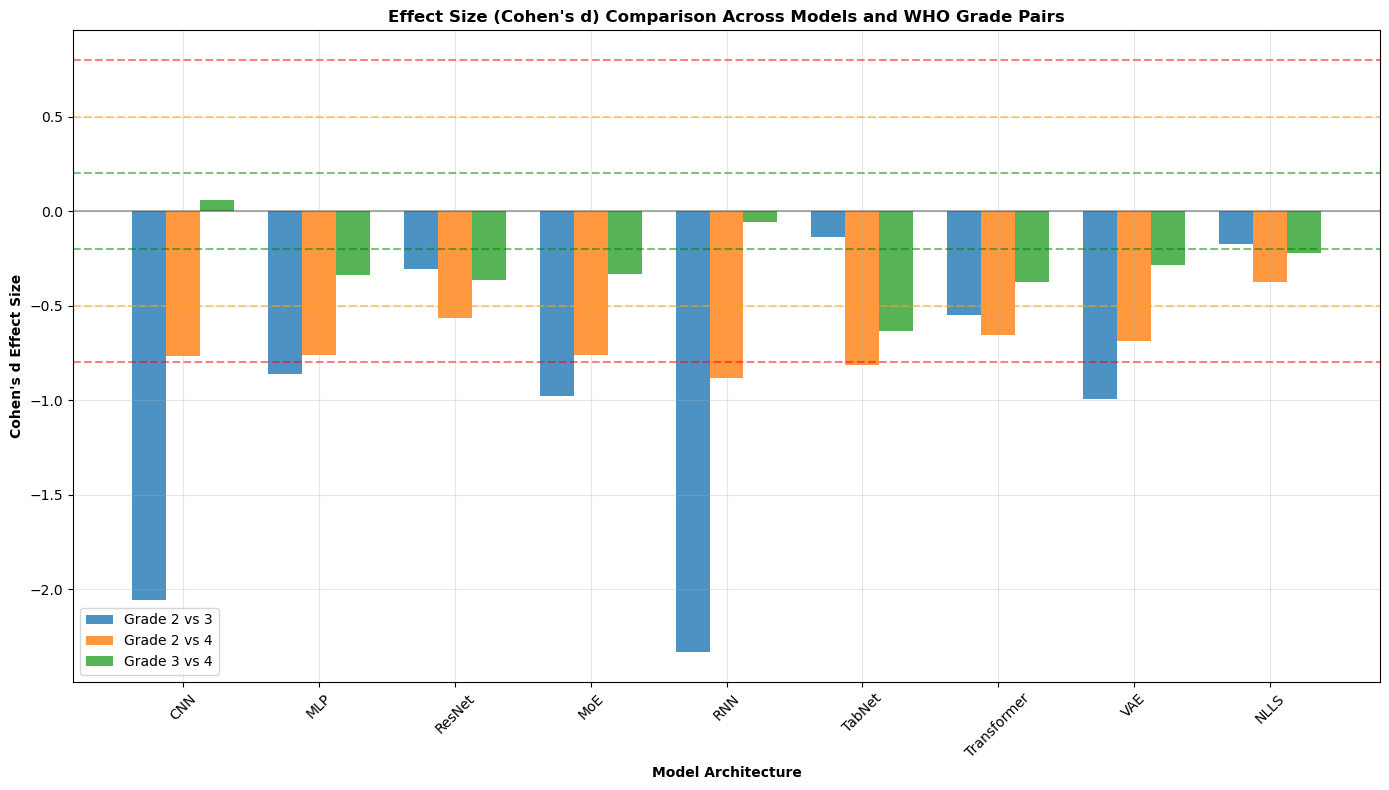

In [19]:
# EFFECT SIZE SUMMARY TABLES AND VISUALIZATIONS
print("\n" + "="*60)
print("EFFECT SIZE SUMMARY TABLES")
print("="*60)

if not effect_size_df.empty:
    # Summary table by comparison type
    print("\nCOHEN'S D BY COMPARISON AND MODEL:")
    cohens_pivot = effect_size_df.pivot(index='model', columns='comparison', values='cohens_d')
    print(cohens_pivot.round(3))
    
    print("\nGLASS'S DELTA BY COMPARISON AND MODEL:")
    glass_pivot = effect_size_df.pivot(index='model', columns='comparison', values='glass_delta')
    print(glass_pivot.round(3))
    
    print("\nCLIFF'S DELTA BY COMPARISON AND MODEL:")
    cliffs_pivot = effect_size_df.pivot(index='model', columns='comparison', values='cliffs_delta')
    print(cliffs_pivot.round(3))
    
    # Effect size magnitude summary
    print("\n" + "="*50)
    print("EFFECT SIZE MAGNITUDE SUMMARY")
    print("="*50)
    
    for comparison in effect_size_df['comparison'].unique():
        comp_data = effect_size_df[effect_size_df['comparison'] == comparison]
        print(f"\n{comparison}:")
        
        print("  Cohen's d interpretations:")
        cohens_counts = comp_data['cohens_interpretation'].value_counts()
        for interp, count in cohens_counts.items():
            print(f"    {interp:10}: {count} models")
            
        print("  Cliff's δ interpretations:")
        cliffs_counts = comp_data['cliffs_interpretation'].value_counts()
        for interp, count in cliffs_counts.items():
            print(f"    {interp:10}: {count} models")
    
    # Create effect size visualization
    print("\n" + "="*60)
    print("EFFECT SIZE VISUALIZATION")
    print("="*60)
    
    # Create comprehensive effect size heatmap
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Effect Size Comparison Across Models and WHO Grade Pairs', 
                 fontsize=16, fontweight='bold')
    
    # Cohen's d heatmap
    sns.heatmap(cohens_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                ax=axes[0], cbar_kws={'label': "Cohen's d"})
    axes[0].set_title("Cohen's d\n(Standardized Mean Difference)", fontweight='bold')
    axes[0].set_xlabel('WHO Grade Comparison')
    axes[0].set_ylabel('Model Architecture')
    
    # Glass's delta heatmap  
    sns.heatmap(glass_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                ax=axes[1], cbar_kws={'label': "Glass's Δ"})
    axes[1].set_title("Glass's Δ\n(Control Group SD)", fontweight='bold')
    axes[1].set_xlabel('WHO Grade Comparison')
    axes[1].set_ylabel('')
    
    # Cliff's delta heatmap
    sns.heatmap(cliffs_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                ax=axes[2], cbar_kws={'label': "Cliff's δ"})
    axes[2].set_title("Cliff's δ\n(Non-parametric)", fontweight='bold')
    axes[2].set_xlabel('WHO Grade Comparison')
    axes[2].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    # Effect size magnitude bar plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Prepare data for grouped bar plot
    models = effect_size_df['model'].unique()
    comparisons = effect_size_df['comparison'].unique()
    
    x = np.arange(len(models))
    width = 0.25
    
    for i, comparison in enumerate(comparisons):
        comp_data = effect_size_df[effect_size_df['comparison'] == comparison]
        cohens_values = []
        
        for model in models:
            model_data = comp_data[comp_data['model'] == model]
            if not model_data.empty:
                cohens_values.append(model_data['cohens_d'].iloc[0])
            else:
                cohens_values.append(0)
        
        ax.bar(x + i*width, cohens_values, width, label=comparison, alpha=0.8)
    
    ax.set_xlabel('Model Architecture', fontweight='bold')
    ax.set_ylabel("Cohen's d Effect Size", fontweight='bold')
    ax.set_title("Effect Size (Cohen's d) Comparison Across Models and WHO Grade Pairs", 
                 fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add effect size interpretation lines
    ax.axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Small effect')
    ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Medium effect')
    ax.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Large effect')
    ax.axhline(y=-0.2, color='green', linestyle='--', alpha=0.5)
    ax.axhline(y=-0.5, color='orange', linestyle='--', alpha=0.5)
    ax.axhline(y=-0.8, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No effect size data available for visualization")

In [20]:
# PATIENT-LEVEL EFFECT SIZE ANALYSIS
print("\n" + "="*60)
print("PATIENT-LEVEL EFFECT SIZE ANALYSIS")
print("="*60)

# Calculate effect sizes using patient-level means (to account for hierarchical structure)
print("Analyzing effect sizes using patient-level aggregated data...")

patient_level_effects = []

for grade1, grade2, comparison_name in grade_comparisons:
    print(f"\n{comparison_name} - Patient-Level Analysis:")
    print("-" * 45)
    
    for model in [spec['name'] for spec in model_specs]:
        # Get patient-level means for each grade
        grade1_patients = patient_summary[
            (patient_summary['who_grade'] == grade1) & 
            (patient_summary['model_name'] == model)
        ]['mean'].values
        
        grade2_patients = patient_summary[
            (patient_summary['who_grade'] == grade2) & 
            (patient_summary['model_name'] == model)
        ]['mean'].values
        
        if len(grade1_patients) > 0 and len(grade2_patients) > 0:
            # Calculate effect sizes on patient means
            cohens = cohens_d(grade1_patients, grade2_patients)
            glass = glass_delta(grade1_patients, grade2_patients, control_group=1)
            cliffs = cliffs_delta(grade1_patients, grade2_patients)
            
            patient_level_effects.append({
                'comparison': comparison_name,
                'model': model,
                'grade1': grade1,
                'grade2': grade2,
                'n_patients_1': len(grade1_patients),
                'n_patients_2': len(grade2_patients),
                'mean_fic_1': np.mean(grade1_patients),
                'mean_fic_2': np.mean(grade2_patients),
                'cohens_d_patients': cohens,
                'glass_delta_patients': glass,
                'cliffs_delta_patients': cliffs,
                'level': 'patient'
            })
            
            print(f"{model:12}: Cohen's d = {cohens:7.3f} ({interpret_effect_size(cohens, 'cohens_d'):10})")
            print(f"             {len(grade1_patients)} vs {len(grade2_patients)} patients, "
                  f"Grade {grade1}: μ={np.mean(grade1_patients):.3f}, "
                  f"Grade {grade2}: μ={np.mean(grade2_patients):.3f}")
        else:
            print(f"{model:12}: Insufficient patient data")

# Convert to DataFrame
patient_effects_df = pd.DataFrame(patient_level_effects)

print(f"\nPatient-level effect size analysis completed for {len(patient_level_effects)} comparisons")

# CLINICAL SIGNIFICANCE ASSESSMENT
print("\n" + "="*60)
print("CLINICAL SIGNIFICANCE ASSESSMENT")
print("="*60)

print("Combining statistical significance with effect size magnitude:")
print("(Requires both p<0.05 AND medium+ effect size for clinical significance)")

# Combine with statistical test results
try:
    from scipy.stats import mannwhitneyu
    
    clinical_significance = []
    
    print(f"\n{'Model':<12} | {'Comparison':<15} | {'p-value':<8} | {'Cohen d':<8} | {'Effect':<10} | {'Clinical Sig':<15}")
    print("-" * 85)
    
    for model in [spec['name'] for spec in model_specs]:
        for grade1, grade2, comparison_name in grade_comparisons:
            # Get voxel-level data for statistical test
            df_model = df[df['model_name'] == model]
            grade1_data = df_model[df_model['who_grade'] == grade1]['fic_value'].values
            grade2_data = df_model[df_model['who_grade'] == grade2]['fic_value'].values
            
            if len(grade1_data) > 0 and len(grade2_data) > 0:
                # Statistical significance
                _, p_value = mannwhitneyu(grade1_data, grade2_data, alternative='two-sided')
                
                # Effect size (voxel-level)
                cohens = cohens_d(grade1_data, grade2_data)
                
                # Clinical significance criteria
                statistically_significant = p_value < 0.05
                medium_or_large_effect = abs(cohens) >= 0.5
                clinically_significant = statistically_significant and medium_or_large_effect
                
                clinical_significance.append({
                    'model': model,
                    'comparison': comparison_name,
                    'p_value': p_value,
                    'cohens_d': cohens,
                    'statistically_significant': statistically_significant,
                    'medium_plus_effect': medium_or_large_effect,
                    'clinically_significant': clinically_significant
                })
                
                # Format output
                sig_star = "*" if statistically_significant else " "
                effect_mag = interpret_effect_size(cohens, 'cohens_d')
                clinical_sig = "YES" if clinically_significant else "NO"
                
                comp_short = comparison_name.replace("Grade ", "").replace(" vs ", "v")
                print(f"{model:<12} | {comp_short:<15} | {p_value:<8.3f}{sig_star} | {cohens:<8.3f} | {effect_mag:<10} | {clinical_sig:<15}")

    # Summary of clinical significance
    clinical_df = pd.DataFrame(clinical_significance)
    
    print(f"\nCLINICAL SIGNIFICANCE SUMMARY:")
    print(f"Total comparisons analyzed: {len(clinical_df)}")
    print(f"Statistically significant (p<0.05): {clinical_df['statistically_significant'].sum()}")
    print(f"Medium+ effect size (|d|≥0.5): {clinical_df['medium_plus_effect'].sum()}")
    print(f"Clinically significant (both criteria): {clinical_df['clinically_significant'].sum()}")
    
    if clinical_df['clinically_significant'].any():
        print(f"\nModels with clinically significant differences:")
        clin_sig_results = clinical_df[clinical_df['clinically_significant']]
        for _, row in clin_sig_results.iterrows():
            print(f"  {row['model']}: {row['comparison']} (p={row['p_value']:.3f}, d={row['cohens_d']:.3f})")

except ImportError:
    print("SciPy not available for statistical significance testing")

print("\n" + "="*60)
print("EFFECT SIZE ANALYSIS COMPLETED")
print("="*60)
print("Summary of effect size metrics added:")
print("• Cohen's d: Standardized mean difference (pooled SD)")
print("• Glass's Δ: Mean difference using control group SD")
print("• Cliff's δ: Non-parametric effect size (probability of superiority)")
print("• Patient-level analysis: Accounts for hierarchical data structure")
print("• Clinical significance: Combines statistical and practical significance")


PATIENT-LEVEL EFFECT SIZE ANALYSIS
Analyzing effect sizes using patient-level aggregated data...

Grade 2 vs 3 - Patient-Level Analysis:
---------------------------------------------
CNN         : Cohen's d =  -1.232 (large     )
             4 vs 5 patients, Grade 2: μ=0.124, Grade 3: μ=0.187
MLP         : Cohen's d =  -0.303 (small     )
             4 vs 5 patients, Grade 2: μ=0.082, Grade 3: μ=0.097
ResNet      : Cohen's d =  -0.275 (small     )
             4 vs 5 patients, Grade 2: μ=0.093, Grade 3: μ=0.112
MoE         : Cohen's d =  -0.311 (small     )
             4 vs 5 patients, Grade 2: μ=0.085, Grade 3: μ=0.108
RNN         : Cohen's d =  -0.921 (large     )
             4 vs 5 patients, Grade 2: μ=0.093, Grade 3: μ=0.131
TabNet      : Cohen's d =  -0.361 (small     )
             4 vs 5 patients, Grade 2: μ=0.138, Grade 3: μ=0.171
Transformer : Cohen's d =  -0.308 (small     )
             4 vs 5 patients, Grade 2: μ=0.090, Grade 3: μ=0.109
VAE         : Cohen's d =  -0.34